#  Balancing Privacy and Accuracy in Machine Learning Models with Differential Privacy

## 1 . Introduction & Problem Statement

This project explores how **Differential Privacy Stochastic Gradient Descent (DP-SGD)** and **Model Agnostic Private Learning (MAPL)** impact machine learning models. Specifically, we examine whether DP techniques interfere with model accuracy and the evolution of machine learning.

## 2 . Setup - Install Required Packages

Run the code below if there are missing packages:

In [1]:
# %pip install matplotlib
# %pip install seaborn
# %pip install pandas
# %pip install scikit-learn==1.3.2
# %pip install ucimlrepo
# %pip install imblearn
# %pip install tabulate
# %pip install boruta
# %pip install torch
# %pip install opacus
# %pip install scipy
# %pip install numpy
# %pip install imbalanced-learn==0.11.0

import importlib.util

required = {
    "matplotlib",
    "seaborn",
    "pandas",
    "ucimlrepo",
    "tabulate",
    "boruta",
    "torch",
    "opacus",
    "scipy",
    "numpy==1.26.4",
    "tqdm",
}

installed = {pkg for pkg in required if importlib.util.find_spec(pkg.split('=')[0]) is not None}
# Special handling for scikit-learn as it may be installed under the name 'sklearn'
if importlib.util.find_spec("sklearn") is not None:
    installed.add("scikit-learn")
# Special handling for imbalanced-learn as it is installed under the name 'imblearn'
if importlib.util.find_spec("imblearn") is not None:
    installed.add("imbalanced-learn")
missing = required - installed

if missing:
    print(f"The following libraries are missing: {', '.join(missing)}")
    print("Attempting to install missing libraries...")
    %pip install {" ".join(missing)}
    print("Libraries installed successfully.")
else:
    print("All required libraries are installed.")

All required libraries are installed.


In [2]:
import os
import pickle

def save_file(data, file_path, params={}):
    if not os.path.exists(os.path.dirname(file_path)):
        print(f"Creating directory: {os.path.dirname(file_path)}")
        os.makedirs(os.path.dirname(file_path))
    if file_path.endswith('.csv'):
        data.to_csv(file_path, index=False, **params)
    elif file_path.endswith('.png') or file_path.endswith('.jpg'):
        data.savefig(file_path)
    elif file_path.endswith('.pkl'):
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
    
results_gInfo_dir = "results/generalInfo"
results_fsData_dir = "results/featureSelectionData"
results_models_dir = "results/models"
models_dir = "models"

## 3 . Data Exploration & Understanding

We are importing the relevant libraries and getting the data:

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo #to retrieve the dataset

# Getting the data
dataset_id = 891  # our chosen dataset
dataset_name = "dataset.csv"
downloaded = os.path.isfile(dataset_name)
df =  pd.read_csv(dataset_name) if downloaded else fetch_ucirepo(id=dataset_id).data.original

# # Previous way to retrieve the dataset (for documentation)
# url = 'https://archive.ics.uci.edu/static/public/891/data.csv'
# df = pd.read_csv(url)

# Save the dataset to a CSV file
if not downloaded:
    print("Dataset not found locally. Downloading...")
    save_file(df, "./" + dataset_name)

# Set display options
pd.set_option('display.max_columns', None)


Dataset not found locally. Downloading...


We have observed that the dataset contains 253,680 records with 23 features:

In [4]:
# Checking basic Dataset Information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (253680, 23)

First 5 rows:


,ID,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,1,1,1,40,1,0,0,0,0,1,0,1,0,5,18,15,1,0,9,4,3
1,1,0,0,0,0,25,1,0,0,1,0,0,0,0,1,3,0,0,0,0,7,6,1
2,2,0,1,1,1,28,0,0,0,0,1,0,0,1,1,5,30,30,1,0,9,4,8
3,3,0,1,0,1,27,0,0,0,1,1,1,0,1,0,2,0,0,0,0,11,3,6
4,4,0,1,1,1,24,0,0,0,1,1,1,0,1,0,2,3,0,0,0,11,5,4


We have observed that all features are stored as integer data types:

The following table shows the features and their descriptions:

| Variable Name     | Role    | Type    | Description                                                                 |
|-------------------|---------|---------|-----------------------------------------------------------------------------|
| ID                | ID      | Integer | Patient ID                                                                  |
| Diabetes_binary   | Target  | Binary  | 0 = no diabetes 1 = prediabetes or diabetes                                 |
| HighBP            | Feature | Binary  | 0 = no high BP 1 = high BP                                                  |
| HighChol          | Feature | Binary  | 0 = no high cholesterol 1 = high cholesterol                                |
| CholCheck         | Feature | Binary  | 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years    |
| BMI               | Feature | Integer | Body Mass Index                                                             |
| Smoker            | Feature | Binary  | Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes |
| Stroke            | Feature | Binary  | (Ever told) you had a stroke. 0 = no 1 = yes                                |
| HeartDiseaseorAttack | Feature | Binary | coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes  |
| PhysActivity      | Feature | Binary  | physical activity in past 30 days - not including job 0 = no 1 = yes        |
| Fruits            | Feature | Binary  | Consume Fruit 1 or more times per day 0 = no 1 = yes                        |
| Veggies           | Feature | Binary  | Consume Vegetables 1 or more times per day 0 = no 1 = yes                   |
| HvyAlcoholConsump | Feature | Binary  | Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no 1 = yes |
| AnyHealthcare     | Feature | Binary  | Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes |
| NoDocbcCost       | Feature | Binary  | Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes |
| GenHlth           | Feature | Integer | General health: 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor |
| MentHlth          | Feature | Integer | For how many days during the past 30 days was your mental health not good? scale 1-30 days |
| PhysHlth          | Feature | Integer | For how many days during the past 30 days was your physical health not good? scale 1-30 days |
| DiffWalk          | Feature | Binary  | Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes   |
| Sex               | Feature | Binary  | 0 = female 1 = male                                                    |
| Age               | Feature | Integer | 13 levels, 1 = 18-24, 9 = 60-64, 13 = 80 or older              |
| Education         | Feature | Integer | 6 levels, 1 = Never attended school or only kindergarten, 2 = Grades 1 through 8, 3 = Grades 9 through 11, 4 = Grade 12 or GED, 5 = College 1 year to 3 years, 6 = College 4 years or more |
| Income            | Feature | Integer | 8 levels, 1 = less than $10,000, 5 = less than $35,000, 8 = $75,000 or more |


In [5]:
# Checking data types
print("\nData Types:")
print(df.dtypes)


Data Types:
ID                      int64
Diabetes_binary         int64
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object


We have observed basic statistics for the features:

In [6]:
# Checking basic statistics
print("\nBasic Statistics:")
print(df.describe())

# Save basic statistics to a CSV file
save_file(df.describe(), os.path.join(results_gInfo_dir, "basic_statistics.csv"))


Basic Statistics:
                  ID  Diabetes_binary         HighBP       HighChol  \
count  253680.000000    253680.000000  253680.000000  253680.000000   
mean   126839.500000         0.139333       0.429001       0.424121   
std     73231.252481         0.346294       0.494934       0.494210   
min         0.000000         0.000000       0.000000       0.000000   
25%     63419.750000         0.000000       0.000000       0.000000   
50%    126839.500000         0.000000       0.000000       0.000000   
75%    190259.250000         0.000000       1.000000       1.000000   
max    253679.000000         1.000000       1.000000       1.000000   

           CholCheck            BMI         Smoker         Stroke  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.962670      28.382364       0.443169       0.040571   
std         0.189571       6.608694       0.496761       0.197294   
min         0.000000      12.000000       0.000000       0.000000

We have observed that there are no missing values (as stated in the dataset description):

In [7]:
# Checking for missing values
print("\nMissing values per column:")
df.isnull().sum()


Missing values per column:


ID                      0
Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

We have observed that the dataset only has 13.93% records with diabetes. We will address this imbalance later during data cleaning and preprocessing:

Distribution of target variable:
0    218334
1     35346
Name: Diabetes_binary, dtype: int64
Percentage of records with diabetes: 13.93%


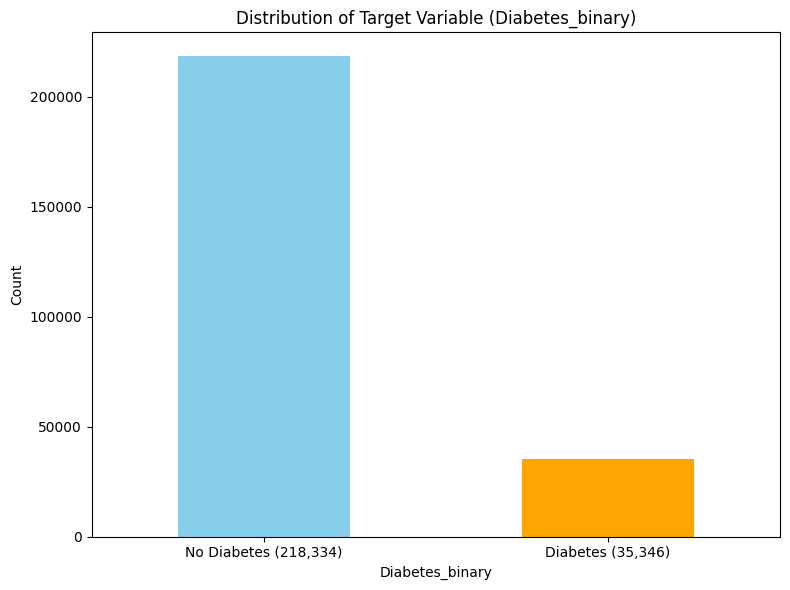

In [8]:
# Checking distribution of dataset
diabetes_counts = df['Diabetes_binary'].value_counts()
print("Distribution of target variable:")
print(diabetes_counts)
print(f"Percentage of records with diabetes: {diabetes_counts[1]/len(df)*100:.2f}%")
# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
diabetes_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Distribution of Target Variable (Diabetes_binary)")
plt.xlabel("Diabetes_binary")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=[f"No Diabetes ({diabetes_counts[0]:,})", f"Diabetes ({diabetes_counts[1]:,})"], rotation=0)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(results_gInfo_dir, "imbalanced_diabetes_distribution.png")
save_file(plt, plot_path)
plt.show()

## 4 . Preprocessing

Usually in preprocessing we would handle missing values, encoding binary data (True &rarr; 1), encoding categorical data, feature scaling. However, since the dataset is already clean and preprocessed, we will only address the class imbalance issue.
In the balanced datased, we have reduced the number of records with diabetes to match the number of records without diabetes, so that the dataset is balanced.

### 4.1 Class Balancing


Original Dataset:
- Total samples in the original dataset: 253680
- Samples with diabetes (class 1): 35346
- Samples without diabetes (class 0): 218334

Balanced Dataset:
- Total samples in the balanced dataset: 70692
1    35346
0    35346
Name: Diabetes_binary, dtype: int64
- Samples without diabetes (class 0): 35346
- Samples with diabetes (class 1): 35346


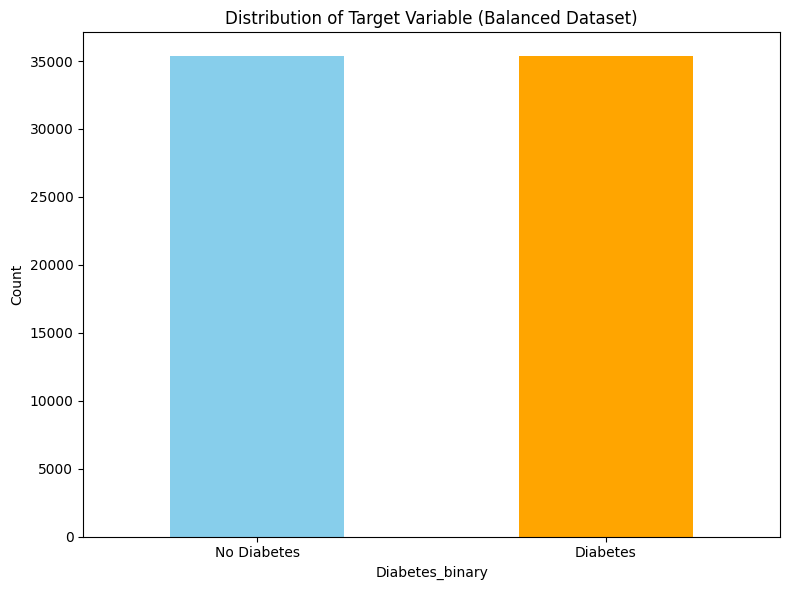

In [9]:
num_with_diabetes = df['Diabetes_binary'].value_counts()[1]

print("\nOriginal Dataset:")
print(f"- Total samples in the original dataset: {len(df)}")
print(f"- Samples with diabetes (class 1): {num_with_diabetes}")
print(f"- Samples without diabetes (class 0): {df['Diabetes_binary'].value_counts()[0]}")

df_no_diabetes = df[df['Diabetes_binary'] == 0].sample(n=num_with_diabetes, random_state=42)
df_with_diabetes = df[df['Diabetes_binary'] == 1]

df_balanced = pd.concat([df_no_diabetes, df_with_diabetes])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced_noTarget = df_balanced.drop(columns=["Diabetes_binary"])
y_balanced = df_balanced["Diabetes_binary"]

print("\nBalanced Dataset:")
print(f"- Total samples in the balanced dataset: {len(df_balanced)}")
print(df_balanced['Diabetes_binary'].value_counts())

print(f"- Samples without diabetes (class 0): {df_balanced['Diabetes_binary'].value_counts()[0]}")
print(f"- Samples with diabetes (class 1): {df_balanced['Diabetes_binary'].value_counts()[1]}")

# Plot the distribution of the balanced dataset
plt.figure(figsize=(8, 6))
df_balanced['Diabetes_binary'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Distribution of Target Variable (Balanced Dataset)")
plt.xlabel("Diabetes_binary")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["No Diabetes", "Diabetes"], rotation=0)
plt.tight_layout()

# Save the plot
plot_path_balanced = os.path.join(results_gInfo_dir, "balanced_diabetes_distribution.png")
save_file(plt, plot_path_balanced)
plt.show()


### 4.2 Data Splitting Strategy 

Before training our models we have to split the data into a training set and a test set. We have chosen a 80/20 split, which ensures we have enough training data for the model to learn patterns and enough data for performance evaluation. We have used stratified sampling to ensure that both the training set and test set includes a 50/50 split of records having diabetes or not.

In [10]:
from sklearn.model_selection import train_test_split


X_balanced = df_balanced.drop('Diabetes_binary', axis=1) # drop the target column
y_balanced = df_balanced['Diabetes_binary']

X_imbalanced = df.drop('Diabetes_binary', axis=1) #drop the target column
y_imbalanced = df['Diabetes_binary']

# split into train (70%) and temp (30%)
X_train_bal, X_temp_bal, y_train_bal, y_temp_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

# split temp set into validation (10%) and test (20%)
X_val_bal, X_test_bal, y_val_bal, y_test_bal = train_test_split(
    X_temp_bal, y_temp_bal, test_size=2/3, random_state=42, stratify=y_temp_bal
)

# Imbalanced dataset
X_train_imb, X_temp_imb, y_train_imb, y_temp_imb = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.3, random_state=42, stratify=y_imbalanced
)

X_val_imb, X_test_imb, y_val_imb, y_test_imb = train_test_split(
    X_temp_imb, y_temp_imb, test_size=2/3, random_state=42, stratify=y_temp_imb
)

print(f"Balanced Training set: {X_train_bal.shape[0]} samples")
print(f"Balanced Validation set: {X_val_bal.shape[0]} samples")
print(f"Balanced Testing set: {X_test_bal.shape[0]} samples")

print("\nClass distribution in balanced training set:")
print(y_train_bal.value_counts(normalize=True))

print("\nClass distribution in balanced validation set:")
print(y_val_bal.value_counts(normalize=True))

print("\nClass distribution in balanced testing set:")
print(y_test_bal.value_counts(normalize=True))

print(f"\nImbalanced Training set: {X_train_imb.shape[0]} samples")
print(f"Imbalanced Validation set: {X_val_imb.shape[0]} samples")
print(f"Imbalanced Testing set: {X_test_imb.shape[0]} samples")

print("\nClass distribution in imbalanced training set:")
print(y_train_imb.value_counts(normalize=True))

print("\nClass distribution in imbalanced validation set:")
print(y_val_imb.value_counts(normalize=True))

print("\nClass distribution in imbalanced testing set:")
print(y_test_imb.value_counts(normalize=True))

Balanced Training set: 49484 samples
Balanced Validation set: 7069 samples
Balanced Testing set: 14139 samples

Class distribution in balanced training set:
1    0.5
0    0.5
Name: Diabetes_binary, dtype: float64

Class distribution in balanced validation set:
1    0.500071
0    0.499929
Name: Diabetes_binary, dtype: float64

Class distribution in balanced testing set:
0    0.500035
1    0.499965
Name: Diabetes_binary, dtype: float64

Imbalanced Training set: 177576 samples
Imbalanced Validation set: 25368 samples
Imbalanced Testing set: 50736 samples

Class distribution in imbalanced training set:
0    0.860668
1    0.139332
Name: Diabetes_binary, dtype: float64

Class distribution in imbalanced validation set:
0    0.860651
1    0.139349
Name: Diabetes_binary, dtype: float64

Class distribution in imbalanced testing set:
0    0.860671
1    0.139329
Name: Diabetes_binary, dtype: float64


### 4.3 Feature Selection

This might be a defense against the attacks, because the less features we have, the less information we leak.

We need to explain which features we have chosen based on the data exploration above and the following feature selection methods. We can use variance threshold, correlation matrix, kbest, rfe, boruta...

['HighBP', 'HighChol', 'BMI', 'GenHlth', 'Age'] ok with V.T. and C.M.

Might want to use more features to try the attacks

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    VarianceThreshold,
    mutual_info_classif,
)
from boruta import BorutaPy
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

def save_results(results, file_path, columns):
    results_df = pd.DataFrame(results, columns=columns)
    if not os.path.exists(os.path.dirname(file_path)):
        os.makedirs(os.path.dirname(file_path))
    results_df.to_csv(file_path, index=False)

def calculate_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    return (accuracy, precision, recall, f1)

def getVariances(threshold, data):
    var_threshold = VarianceThreshold(threshold=threshold)
    var_threshold.fit(data)
    variances = var_threshold.variances_
    # Create a DataFrame for variances
    variances_df = pd.DataFrame(variances, index=data.columns, columns=["Variance"])
    # Sort variances in descending order
    variances_df = variances_df.sort_values(by="Variance", ascending=False)
    # Features with variance >= threshold
    features_high_variance = variances_df[variances_df["Variance"] >= threshold]
    # Features with variance < threshold
    features_low_variance = variances_df[variances_df["Variance"] < threshold]
    return variances_df, features_high_variance, features_low_variance

def getKBest(k, data, target):
    # selection
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    x_kbest = selector.fit_transform(data, target)
    # Create a DataFrame with the selected features
    kbest_features = data.columns[selector.get_support()]
    x_kbest_df = pd.DataFrame(x_kbest, columns=kbest_features)
    return x_kbest_df

def process_kbest(data, target, k, file_path):
    try:
        x_kbest_df = pd.read_csv(file_path)
    except FileNotFoundError:
        x_kbest_df = getKBest(k, data, target)
        x_kbest_df[target.name] = target.values
        x_kbest_df.to_csv(file_path, index=False)
    x_kbest_df = x_kbest_df.drop(columns=[target.name], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(
        x_kbest_df, target, test_size=0.3, random_state=42, stratify=target
    )
    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_test)
    accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)
    kbest_features_names = x_kbest_df.columns.tolist()
    return (k, accuracy, precision, recall, f1, kbest_features_names)

def getRFE(k, data, target):
    # selection
    selector = RFE(estimator=rf_model, n_features_to_select=k)
    x_rfe = selector.fit_transform(data, target)
    # Create a DataFrame with the selected features
    rfe_features = data.columns[selector.get_support()]
    x_rfe_df = pd.DataFrame(x_rfe, columns=rfe_features)
    return x_rfe_df

def process_rfe(data, target, k, file_path):
    try:
        x_rfe_df = pd.read_csv(file_path)
    except FileNotFoundError:
        x_rfe_df = getRFE(k, data, target)
        x_rfe_df[target.name] = target.values
        x_rfe_df.to_csv(file_path, index=False)
    x_rfe_df = x_rfe_df.drop(columns=[target.name], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(
        x_rfe_df, target, test_size=0.3, random_state=42, stratify=target
    )
    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_test)
    accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)
    rfe_features_names = x_rfe_df.columns.tolist()
    return (k, accuracy, precision, recall, f1, rfe_features_names)

def apply_boruta(data, target):
    x_train, x_test, y_train, y_test = train_test_split(
        data, target, test_size=0.3, random_state=42, stratify=target
    )
    boruta = BorutaPy(
        rf_model,
        n_estimators="auto",
        verbose=2,
        random_state=42,
    )
    boruta.fit(x_train.values, y_train.values)
    sel_x_train = boruta.transform(x_train.values)
    sel_x_test = boruta.transform(x_test.values)
    rf_model.fit(sel_x_train, y_train)
    y_pred = rf_model.predict(sel_x_test)
    accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)
    selected_features = x_train.columns[boruta.support_].tolist()
    return (accuracy, precision, recall, f1, selected_features)

#### 4.3.1 Variance Threshold

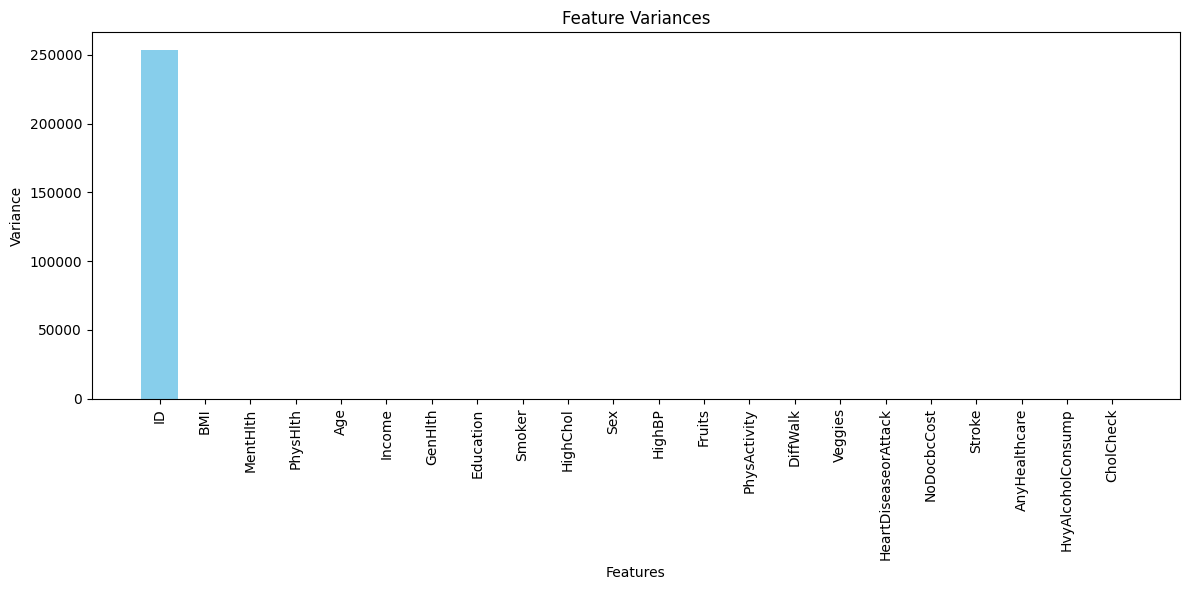


Features with High Variance:
                           Variance
ID                    253675.000000
BMI                       51.546192
MentHlth                  30.000000
PhysHlth                  30.000000
Age                        8.097407
Income                     4.720747
GenHlth                    1.238609
Education                  1.063818
Smoker                     0.249415
HighChol                   0.249212
Sex                        0.248249
HighBP                     0.246048
Fruits                     0.237552
PhysActivity               0.208977
DiffWalk                   0.189228
Veggies                    0.168074
HeartDiseaseorAttack       0.126768
NoDocbcCost                0.085646
Stroke                     0.058393
AnyHealthcare              0.043732
HvyAlcoholConsump          0.041348
CholCheck                  0.023739

Features with Low Variance:
Empty DataFrame
Columns: [Variance]
Index: []


In [12]:
variances_df, features_high_variance, features_low_variance = getVariances(
    0, df_balanced_noTarget
)

# Plot variances of all features
plt.figure(figsize=(12, 6))
plt.bar(variances_df.index, variances_df['Variance'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Feature Variances')
plt.tight_layout()
plt.show()

# Highlight features with high and low variance
print("\nFeatures with High Variance:")
print(features_high_variance)
print("\nFeatures with Low Variance:")
print(features_low_variance)

#### 4.3.2 Correlation Matrix

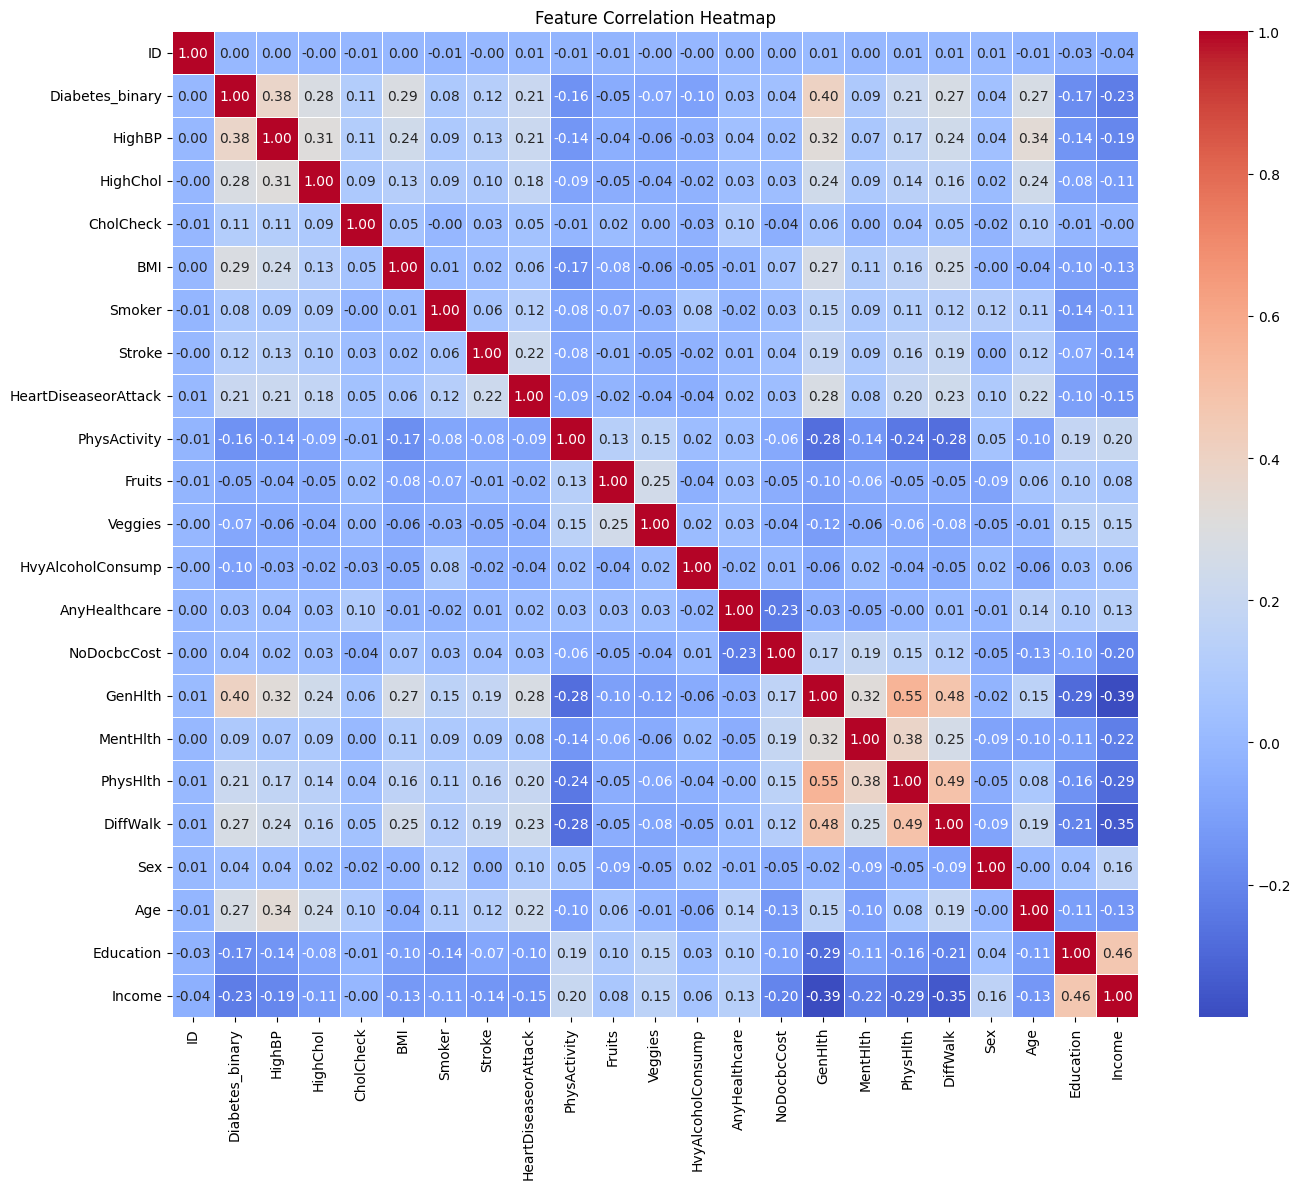


Features correlated with Diabetes (sorted):
Diabetes_binary         1.000000
GenHlth                 0.403482
HighBP                  0.382655
BMI                     0.287082
HighChol                0.284526
Age                     0.274373
DiffWalk                0.270656
PhysHlth                0.211926
HeartDiseaseorAttack    0.207632
Stroke                  0.124924
CholCheck               0.113663
MentHlth                0.091290
Smoker                  0.084918
Sex                     0.042076
NoDocbcCost             0.038524
AnyHealthcare           0.026787
ID                      0.003379
Fruits                 -0.053606
Veggies                -0.072736
HvyAlcoholConsump      -0.096767
PhysActivity           -0.157506
Education              -0.170107
Income                 -0.225386
Name: Diabetes_binary, dtype: float64


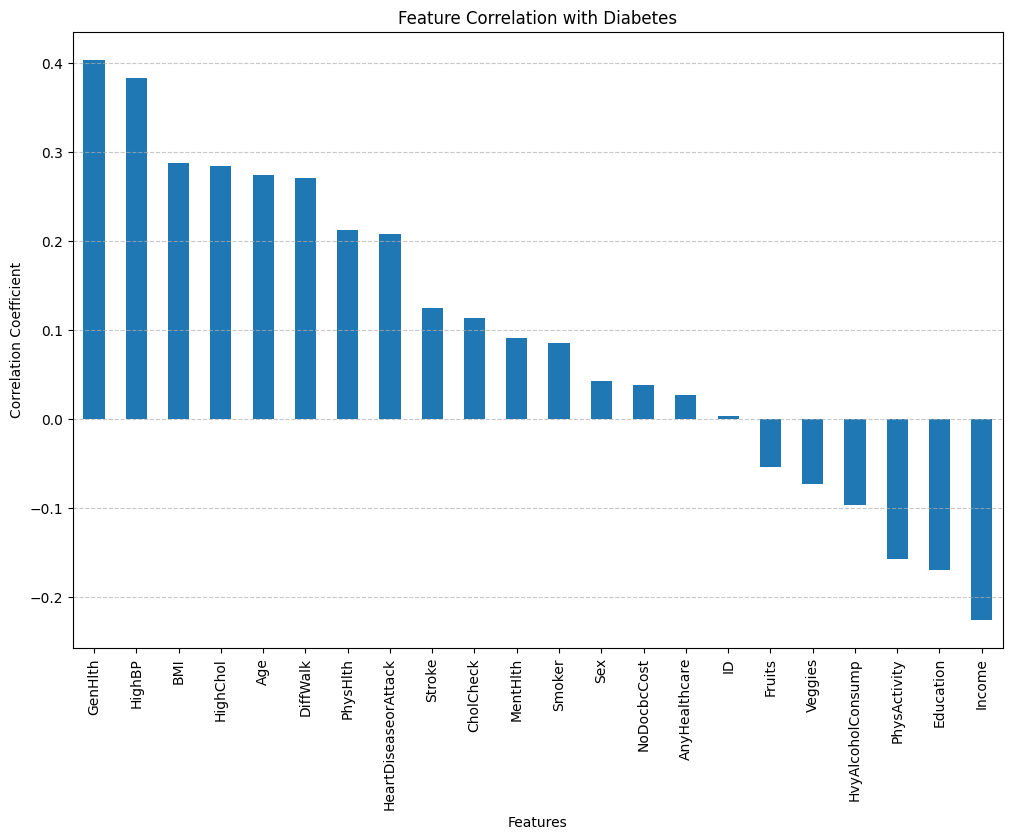

In [13]:
# Calculate correlation matrix
correlation_matrix = df_balanced.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Focus on correlations with the target variable
diabetes_correlations = correlation_matrix['Diabetes_binary'].sort_values(ascending=False)
print("\nFeatures correlated with Diabetes (sorted):")
print(diabetes_correlations)

# Visualize correlations with the target
plt.figure(figsize=(12, 8))
diabetes_correlations[1:].plot(kind='bar')  # Exclude self-correlation
plt.title("Feature Correlation with Diabetes")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 4.3.3 KBest

In [14]:
# results = []
# columns = ["Model", "K", "Accuracy", "Precision", "Recall", "F1-Score", "Features"]
# for k in range(1, df_balanced_noTarget.shape[1] + 1):
#     file_path = f"featureSelectionData/kbest/k/{k}best_features.csv"
#     kbestResult = process_kbest(df_balanced_noTarget, y_balanced, k, file_path)
#     results.append(("rf",) + kbestResult)
# save_results(
#     results, f"featureSelectionData/kbest/kbest_rf_results.csv", columns
# )

#### 4.3.4 RFE

In [15]:
# results = []
# columns = ["Model", "K", "Accuracy", "Precision", "Recall", "F1-Score", "Features"]
# for k in range(1, df_balanced_noTarget.shape[1] + 1):
#     file_path = f"featureSelectionData/rfe/k/{k}rfe_features.csv"
#     rfeResult = process_rfe(df_balanced_noTarget, y_balanced, k, file_path)
#     results.append(("rf",) + rfeResult)
# save_results(results, f"featureSelectionData/rfe/rfe_rf_results.csv", columns)


#### 4.3.5 Boruta

In [16]:
# columns = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Features"]
# accuracy, precision, recall, f1, selected_features = apply_boruta(
#     df_balanced_noTarget, y_balanced
# )
# save_results(
#     [("rf", accuracy, precision, recall, f1, selected_features)],
#     f"featureSelectionData/boruta/boruta_rf_results.csv",
#     columns,
# )

#### 4.3.6 Feature sets

In [17]:
manual_important_features = ['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'Age', 
                      'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth', 
                      'CholCheck', 'Smoker', 'NoDocbcCost', 'Sex', 'AnyHealthcare', 
                      'Income', 'Education']
important_features = ['HighBP', 'HighChol', 'BMI', 'GenHlth', 'Age', 'Income']

## 5 . Machine Learning Model without Differential Privacy

- Precision: How many predicted positives are actually positive?
- Recall: How many actual positives were correctly identified?
- F1-score: A balance between precision and recall.
- Support: Number of actual occurrences of each class.

Single-layer networks have just one layer of active units. Inputs connect directly to the outputs through a single layer of weights.

In multi-layer networks (MLP) there is a layer of input nodes, a layer of output nodes, and one or more intermediate (hidden) layers.

- Input Layer: Input variables, sometimes called the visible layer.
- Hidden Layers: Layers of nodes between the input and output layers. There may be one or more of these layers.
- Output Layer: A layer of nodes that produce the output variables.
- Size: The number of nodes in the model.
- Width: The number of nodes in a specific layer.
- Depth: The number of layers in a neural network.

The structure of an MLP can be summarized using a simple notation: the number of nodes in each layer is specified as an integer, in order from the input layer to the output layer, with the size of each layer separated by a "/". For example, a model with 3 input nodes, 2 hidden layers with 4 and 3 nodes respectively, and 1 output node would be represented as "3/4/3/1".

Steps to train a deep learning model with pytorch:
1. Scale the data
2. Label encode the target
3. Convert the data to tensors
4. Create a model
   1. Should we use a wide model or a deep model? 
   2. How many layers and neurons per layer should we use?
   3. How to choose? K-fold cross validaton
5. Train the model

K-fold cross validaton is a technique that, use a “training set” of data to train the model and then use a “test set” of data to see how accurate the model can predict. The result from test set is what we should focus on. But we do not want to test a model once because if we see an extremely good or bad result, it may be by chance. we want to run this process times with different training and test sets, such that we are ensured that we are comparing the model design, not the result of a particular training. K-fold cross validaton splits a larger dataset into portions and take one portion as the test set while the portions are combined as the training set. There are different such combinations. Therefore we can repeat the experiment for times and take the average result. To ensure that each portion contains equal number of classes we will use stratified k-fold cross validation.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import tqdm
import copy

models_performance_path = os.path.join(results_models_dir, 'models_performance.csv')

# Define the model
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)  # Binary classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)
    
# 3 layers model (input, 1 hidden, output)
class Wide(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden = nn.Linear(n_features, n_features * 3)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n_features * 3, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
# 5 layers model (input, 3 hidden, output)
class Deep(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer1 = nn.Linear(n_features, n_features)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(n_features, n_features)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(n_features, n_features)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
 
# Compare model sizes (number of nodes)
# modelWide = Wide(df_balanced.shape[1])
# modelDeep = Deep(df_balanced.shape[1])
# print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))
# print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))

def get_train_test_tensors(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

def getLoader(X_train_tensor, y_train_tensor):
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    return train_loader
 
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy TODO: OR nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # TODO: OR optim.SGD()
 
    n_epochs = 1    # number of epochs to run TODO: how many?
    batch_size = 10 # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity TODO: change with precision
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar: # tqdm is a progress bar
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    
    return best_acc, model

def save_model_performance(classification_report_dict, model_name):
    performance = {
        "Model": model_name,
        "Accuracy": classification_report_dict["accuracy"],
        "Precision_0": classification_report_dict["0"]["precision"],
        "Precision_1": classification_report_dict["1"]["precision"],
        "Precision_weighted": classification_report_dict["weighted avg"]["precision"],
        "Recall_0": classification_report_dict["0"]["recall"],
        "Recall_1": classification_report_dict["1"]["recall"],
        "Recall_weighted": classification_report_dict["weighted avg"]["recall"],
        "F1_0": classification_report_dict["0"]["f1-score"],
        "F1_1": classification_report_dict["1"]["f1-score"],
        "F1_weighted": classification_report_dict["weighted avg"]["f1-score"],
        "Support_0": classification_report_dict["0"]["support"],
        "Support_1": classification_report_dict["1"]["support"],
        "Support_weighted": classification_report_dict["weighted avg"]["support"],
    }
    if os.path.isfile(models_performance_path,):
        existing_data = pd.read_csv(models_performance_path)
        if performance["Model"] not in existing_data["Model"].values:
            save_file(pd.DataFrame([performance]), models_performance_path, {'mode': 'a', 'header': False})
        else:
            existing_data.loc[existing_data["Model"] == performance["Model"], :] = pd.DataFrame([performance]).values
            save_file(existing_data, models_performance_path)
    else:
        save_file(pd.DataFrame([performance]), models_performance_path)

### 5.1 Comparing Models with Cross-Validation

In [19]:
# # Convert the data to tensors PyTorch tensors as this is the format a PyTorch model needs
# from sklearn.metrics import roc_curve
# from sklearn.model_selection import StratifiedKFold

# n_features = X_train_bal.shape[1]
# train_test_tensors_allF_bal = get_train_test_tensors(X_train_bal, y_train_bal, 
#                                                      X_test_bal, y_test_bal)
# X_train_tensor_allF_bal = train_test_tensors_allF_bal[0]
# y_train_tensor_allF_bal = train_test_tensors_allF_bal[1]
# X_test_tensor_allF_bal = train_test_tensors_allF_bal[2]
# y_test_tensor_allF_bal = train_test_tensors_allF_bal[3]

# kfold = StratifiedKFold(n_splits=5, shuffle=True)
# cv_scores_wide = []
# for train, test in kfold.split(X_train_tensor_allF_bal, y_train_tensor_allF_bal):
#     # Create model, train and get accuracy
#     model = Wide(n_features)
#     acc, model = model_train(model, X_train_tensor_allF_bal[train], y_train_tensor_allF_bal[train],
#                       X_train_tensor_allF_bal[test], y_train_tensor_allF_bal[test])
#     print(f"Accuracy (wide): {acc:.4f}")
#     cv_scores_wide.append(acc)
# cv_scores_deep = []
# for train, test in kfold.split(X_train_tensor_allF_bal, y_train_tensor_allF_bal):
#     # Create model, train and get accuracy
#     model = Deep(n_features)
#     acc, model = model_train(model, X_train_tensor_allF_bal[train], y_train_tensor_allF_bal[train],
#                       X_train_tensor_allF_bal[test], y_train_tensor_allF_bal[test])
#     print(f"Accuracy (deep): {acc:.4f}")
#     cv_scores_deep.append(acc)

# # Evaluate the model
# wide_acc = np.mean(cv_scores_wide)
# wide_std = np.std(cv_scores_wide)
# deep_acc = np.mean(cv_scores_deep)
# deep_std = np.std(cv_scores_deep)
# print(f"Wide: {wide_acc*100:.2f}% (+/- {wide_std*100:.2f}%)")
# print(f"Deep: {deep_acc*100:.2f}% (+/- {deep_std*100:.2f}%)")

# # Rebuild model with full training set
# if wide_acc > deep_acc:
#     print("Retraining Wide model")
#     model = Wide(n_features)
# else:
#     print("Retraining Deep model")
#     model = Deep(n_features)
# acc, model = model_train(model, X_train_tensor_allF_bal, y_train_tensor_allF_bal,
#                   X_test_tensor_allF_bal, y_test_tensor_allF_bal)
# print(f"Accuracy (final): {acc:.4f}")

# # Save model
# save_file(model, os.path.join(models_dir, 'deepL_allF_bal_model.pkl'))

# model.eval()
# with torch.no_grad():
#     # Test out inference with 5 samples
#     for i in range(5):
#         y_pred = model(X_test_tensor_allF_bal[i:i+1])
#         print(f"{X_test_tensor_allF_bal[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test_tensor_allF_bal[i].numpy()})")
        
#     # Plot the ROC curve
#     y_pred = model(X_test_tensor_allF_bal)
#     fpr, tpr, thresholds = roc_curve(y_test_tensor_allF_bal, y_pred)
#     plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
#     plt.title("Receiver Operating Characteristics")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.show()

### 5.2 Using all features (balanced dataset)

In [20]:
# Convert the data to tensors PyTorch tensors as this is the format a PyTorch model needs
train_test_tensors_allF_bal = get_train_test_tensors(X_train_bal, y_train_bal, 
                                                     X_test_bal, y_test_bal)
X_train_tensor_allF_bal = train_test_tensors_allF_bal[0]
y_train_tensor_allF_bal = train_test_tensors_allF_bal[1]
X_test_tensor_allF_bal = train_test_tensors_allF_bal[2]
y_test_tensor_allF_bal = train_test_tensors_allF_bal[3]

train_loader_allF_bal = getLoader(X_train_tensor_allF_bal, y_train_tensor_allF_bal)

model_allF_bal = FeedForwardNN(input_dim=X_train_tensor_allF_bal.shape[1])
optimizer_allF_bal = optim.SGD(model_allF_bal.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 5
print("Training neural network model...")
for epoch in range(num_epochs):
    model_allF_bal.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader_allF_bal:
        optimizer_allF_bal.zero_grad()
        output = model_allF_bal(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer_allF_bal.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_allF_bal):.4f}")

# Evaluate the model
model_allF_bal.eval()
with torch.no_grad():
    predictions = model_allF_bal(X_test_tensor_allF_bal)
    predicted_classes = torch.argmax(predictions, dim=1)
    
    # Convert to numpy for sklearn metrics
    y_pred = predicted_classes.numpy()
    y_true = y_test_tensor_allF_bal.numpy()
    
    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

save_file(model_allF_bal, os.path.join(models_dir, 'deepL_allF_bal_model.pkl'))
# Save model performance
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
save_model_performance(classification_report_dict, 'deepL_allF_bal')

Training neural network model...
Epoch 1, Loss: 0.5794
Epoch 2, Loss: 0.5243
Epoch 3, Loss: 0.5173
Epoch 4, Loss: 0.5148
Epoch 5, Loss: 0.5131
Accuracy: 0.7510

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.74      7070
           1       0.72      0.81      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139

Creating directory: results/models


### 5.3 Using manually selected features (balanced dataset)

In [21]:
X_train_bal_manSelF = X_train_bal[manual_important_features]
X_test_bal_manSelF = X_test_bal[manual_important_features]
train_test_tensors_manSelF_bal = get_train_test_tensors(X_train_bal_manSelF, y_train_bal,
                                                     X_test_bal_manSelF, y_test_bal)
X_train_tensor_manSelF_bal = train_test_tensors_manSelF_bal[0]
y_train_tensor_manSelF_bal = train_test_tensors_manSelF_bal[1]
X_test_tensor_manSelF_bal = train_test_tensors_manSelF_bal[2]
y_test_tensor_manSelF_bal = train_test_tensors_manSelF_bal[3]

train_loader_manSelF_bal = getLoader(X_train_tensor_manSelF_bal, y_train_tensor_manSelF_bal)

model_manSelF_bal = FeedForwardNN(input_dim=X_train_tensor_manSelF_bal.shape[1])
optimizer_manSelF_bal = optim.SGD(model_manSelF_bal.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 5
print("Training neural network model with important features...")
for epoch in range(num_epochs):
    model_manSelF_bal.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader_manSelF_bal:
        optimizer_manSelF_bal.zero_grad()
        output = model_manSelF_bal(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer_manSelF_bal.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_manSelF_bal):.4f}")

# Evaluate the model
model_manSelF_bal.eval()
with torch.no_grad():
    predictions = model_manSelF_bal(X_test_tensor_manSelF_bal)
    predicted_classes = torch.argmax(predictions, dim=1)
    
    # Convert to numpy for sklearn metrics
    y_pred = predicted_classes.numpy()
    y_true = y_test_tensor_manSelF_bal.numpy()
    
    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

save_file(model_manSelF_bal, os.path.join(models_dir, 'deepL_manSelF_bal_model.pkl'))
# Save model performance
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
save_model_performance(classification_report_dict, 'deepL_manSelF_bal')

Training neural network model with important features...
Epoch 1, Loss: 0.5692
Epoch 2, Loss: 0.5239
Epoch 3, Loss: 0.5174
Epoch 4, Loss: 0.5147
Epoch 5, Loss: 0.5130
Accuracy: 0.7498

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      7070
           1       0.72      0.82      0.77      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



### 5.4 Using selected features (balanced dataset)

In [22]:
X_train_bal_selF = X_train_bal[important_features]
X_test_bal_selF = X_test_bal[important_features]
train_test_tensors_selF_bal = get_train_test_tensors(X_train_bal_selF, y_train_bal,
                                                     X_test_bal_selF, y_test_bal)
X_train_tensor_selF_bal = train_test_tensors_selF_bal[0]
y_train_tensor_selF_bal = train_test_tensors_selF_bal[1]
X_test_tensor_selF_bal = train_test_tensors_selF_bal[2]
y_test_tensor_selF_bal = train_test_tensors_selF_bal[3]

train_loader_selF_bal = getLoader(X_train_tensor_selF_bal, y_train_tensor_selF_bal)

model_selF_bal = FeedForwardNN(input_dim=X_train_tensor_selF_bal.shape[1])
optimizer_selF_bal = optim.SGD(model_selF_bal.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 5
print("Training neural network model with selected features...")
for epoch in range(num_epochs):
    model_selF_bal.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader_selF_bal:
        optimizer_selF_bal.zero_grad()
        output = model_selF_bal(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer_selF_bal.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_selF_bal):.4f}")

# Evaluate the model
model_selF_bal.eval()
with torch.no_grad():
    predictions = model_selF_bal(X_test_tensor_selF_bal)
    predicted_classes = torch.argmax(predictions, dim=1)
    
    # Convert to numpy for sklearn metrics
    y_pred = predicted_classes.numpy()
    y_true = y_test_tensor_selF_bal.numpy()
    
    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

save_file(model_selF_bal, os.path.join(models_dir, 'deepL_selF_bal_model.pkl'))
# Save model performance
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
save_model_performance(classification_report_dict, 'deepL_selF_bal')

Training neural network model with selected features...
Epoch 1, Loss: 0.5519
Epoch 2, Loss: 0.5222
Epoch 3, Loss: 0.5190
Epoch 4, Loss: 0.5170
Epoch 5, Loss: 0.5160
Accuracy: 0.7462

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      7070
           1       0.72      0.80      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



### 5.5 Using selected features (imbalanced dataset)

**This model over prioritizes the majority class (0 - no diabetes), as it was trained with the imbalanced data.**

Comparison:

Balanced data (6.2) - Lower accuracy (74%) but much better at detecting class 1 - diabetes (79%), as it gives the same importance to both classes.

Imbalanced data (6.3) - Higher accuracy (86%) but poor detection of class 1 - diabetes (16%).

In [23]:
# Filter the imbalanced training and test sets to include only important features
X_train_imb_selF = X_train_imb[important_features]
X_test_imb_selF = X_test_imb[important_features]
train_test_tensors_selF_imb = get_train_test_tensors(X_train_imb_selF, y_train_imb,
                                                     X_test_imb_selF, y_test_imb)
X_train_tensor_selF_imb = train_test_tensors_selF_imb[0]
y_train_tensor_selF_imb = train_test_tensors_selF_imb[1]
X_test_tensor_selF_imb = train_test_tensors_selF_imb[2]
y_test_tensor_selF_imb = train_test_tensors_selF_imb[3]

train_loader_selF_imb = getLoader(X_train_tensor_selF_imb, y_train_tensor_selF_imb)

model_selF_imb = FeedForwardNN(input_dim=X_train_tensor_selF_imb.shape[1])
optimizer_selF_imb = optim.SGD(model_selF_imb.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 5
print("Training neural network model with selected features on imbalanced data...")
for epoch in range(num_epochs):
    model_selF_imb.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader_selF_imb:
        optimizer_selF_imb.zero_grad()
        output = model_selF_imb(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer_selF_imb.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_selF_imb):.4f}")

# Evaluate the model
model_selF_imb.eval()
with torch.no_grad():
    predictions = model_selF_imb(X_test_tensor_selF_imb)
    predicted_classes = torch.argmax(predictions, dim=1)
    
    # Convert to numpy for sklearn metrics
    y_pred = predicted_classes.numpy()
    y_true = y_test_tensor_selF_imb.numpy()
    
    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Check class distribution in predictions
    unique, counts = np.unique(y_pred, return_counts=True)
    pred_distribution = dict(zip(unique, counts))
    print(f"Prediction distribution: {pred_distribution}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
save_file(model_selF_imb, os.path.join(models_dir, 'deepL_selF_imb_model.pkl'))
# Save model performance
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
save_model_performance(classification_report_dict, 'deepL_selF_imb')

Training neural network model with selected features on imbalanced data...
Epoch 1, Loss: 0.3330
Epoch 2, Loss: 0.3175
Epoch 3, Loss: 0.3169
Epoch 4, Loss: 0.3167
Epoch 5, Loss: 0.3166
Accuracy: 0.8640
Prediction distribution: {0: 48939, 1: 1797}

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43667
           1       0.55      0.14      0.22      7069

    accuracy                           0.86     50736
   macro avg       0.71      0.56      0.57     50736
weighted avg       0.83      0.86      0.83     50736



#### 5.5.1 Using validation set

In [24]:
# Filter datasets to include only important features
X_train_bal_selF = X_train_bal[important_features]
X_test_bal_selF = X_test_bal[important_features]
X_val_bal_selF = X_val_bal[important_features]

# Scale the data
scaler = StandardScaler()
X_train_scaled_selF = scaler.fit_transform(X_train_bal_selF)
X_test_scaled_selF = scaler.transform(X_test_bal_selF)
X_val_scaled_selF = scaler.transform(X_val_bal_selF)

# Convert to PyTorch tensors
X_train_tensor_selF = torch.tensor(X_train_scaled_selF, dtype=torch.float32)
y_train_tensor_selF = torch.tensor(y_train_bal.values, dtype=torch.long)

X_test_tensor_selF = torch.tensor(X_test_scaled_selF, dtype=torch.float32)
y_test_tensor_selF = torch.tensor(y_test_bal.values, dtype=torch.long)

X_val_tensor_selF = torch.tensor(X_val_scaled_selF, dtype=torch.float32)
y_val_tensor_selF = torch.tensor(y_val_bal.values, dtype=torch.long)

# Create dataset and dataloader
train_dataset_selF = TensorDataset(X_train_tensor_selF, y_train_tensor_selF)
train_loader_selF = DataLoader(train_dataset_selF, batch_size=64, shuffle=True)

# Initialize model with input dimension matching the number of selected features
model_selF = FeedForwardNN(input_dim=len(important_features))
criterion = nn.CrossEntropyLoss()
optimizer_selF = optim.SGD(model_selF.parameters(), lr=0.01)

# Train the model
num_epochs = 5
print("Training neural network model with selected features and validation...")
for epoch in range(num_epochs):
    # Training
    model_selF.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader_selF:
        optimizer_selF.zero_grad()
        output = model_selF(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer_selF.step()
        running_loss += loss.item()
    
    # Validation
    model_selF.eval()
    with torch.no_grad():
        val_output = model_selF(X_val_tensor_selF)
        val_loss = criterion(val_output, y_val_tensor_selF)
        val_predicted = torch.argmax(val_output, dim=1)
        val_acc = (val_predicted == y_val_tensor_selF).float().mean().item()
    
    print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader_selF):.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Final evaluation on test set
model_selF.eval()
with torch.no_grad():
    predictions = model_selF(X_test_tensor_selF)
    predicted_classes = torch.argmax(predictions, dim=1)
    
    # Convert to numpy for sklearn metrics
    y_pred = predicted_classes.numpy()
    y_true = y_test_tensor_selF.numpy()
    
    # Calculate accuracy
    test_acc = accuracy_score(y_true, y_pred)
    print(f"\nBalanced Test Accuracy: {test_acc:.4f}")
    
    # Classification report
    print("\nBalanced Test Classification Report:")
    print(classification_report(y_true, y_pred))

# Evaluate validation set
with torch.no_grad():
    val_predictions = model_selF(X_val_tensor_selF)
    val_predicted_classes = torch.argmax(val_predictions, dim=1)
    
    # Convert to numpy for sklearn metrics
    y_pred_val = val_predicted_classes.numpy()
    y_val_true = y_val_tensor_selF.numpy()
    
    # Calculate accuracy
    val_acc = accuracy_score(y_val_true, y_pred_val)
    print(f"\nBalanced Validation Accuracy: {val_acc:.4f}")
    
    # Classification report
    print("\nBalanced Validation Classification Report:")
    print(classification_report(y_val_true, y_pred_val))

Training neural network model with selected features and validation...
Epoch 1, Training Loss: 0.5551, Validation Loss: 0.5226, Validation Accuracy: 0.7366
Epoch 2, Training Loss: 0.5191, Validation Loss: 0.5201, Validation Accuracy: 0.7346
Epoch 3, Training Loss: 0.5176, Validation Loss: 0.5188, Validation Accuracy: 0.7387
Epoch 4, Training Loss: 0.5160, Validation Loss: 0.5180, Validation Accuracy: 0.7389
Epoch 5, Training Loss: 0.5148, Validation Loss: 0.5176, Validation Accuracy: 0.7399

Balanced Test Accuracy: 0.7471

Balanced Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.74      7070
           1       0.73      0.79      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139


Balanced Validation Accuracy: 0.7399

Balanced Validation Classification Report:
              precision  

### 5.6 Applying Differential Privacy Techniques

#### 5.6.1 Gradient Descent

In [26]:
import opacus

print(np.__version__) # min 1.21
print(opacus.__version__) # min 1.3

1.23.5
1.5.3


##### 5.6.1.1 allF_bal

In [27]:
train_test_tensors_allF_bal = get_train_test_tensors(X_train_bal, y_train_bal, 
                                                     X_test_bal, y_test_bal)
X_train_tensor_allF_bal = train_test_tensors_allF_bal[0]
y_train_tensor_allF_bal = train_test_tensors_allF_bal[1]
X_test_tensor_allF_bal = train_test_tensors_allF_bal[2]
y_test_tensor_allF_bal = train_test_tensors_allF_bal[3]

train_loader_allF_bal = getLoader(X_train_tensor_allF_bal, y_train_tensor_allF_bal)

model_allF_bal = FeedForwardNN(input_dim=X_train_tensor_allF_bal.shape[1])
optimizer_allF_bal = optim.SGD(model_allF_bal.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

privacy_engine = opacus.PrivacyEngine()
model_allF_bal, optimizer_allF_bal, train_loader_allF_bal = privacy_engine.make_private_with_epsilon(
    module=model_allF_bal,
    optimizer=optimizer_allF_bal,
    data_loader=train_loader_allF_bal,
    target_epsilon=5.0,     # Set desired privacy budget
    target_delta=1e-5,
    max_grad_norm=1.0,
    epochs=5
)

# Train the model
model_allF_bal.train()
for epoch in range(5):
    for X_batch, y_batch in train_loader_allF_bal:
        optimizer_allF_bal.zero_grad()
        output = model_allF_bal(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer_allF_bal.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
# Evaluate the model
model_allF_bal.eval()
with torch.no_grad():
    predictions = model_allF_bal(X_test_tensor_allF_bal)
    predicted_classes = torch.argmax(predictions, dim=1)
    # Convert to numpy for sklearn metrics
    y_pred = predicted_classes.numpy()
    y_true = y_test_tensor_allF_bal.numpy()
    # Calculate accuracy
    acc_allF_bal = accuracy_score(y_true, y_pred)
    print(f"Accuracy (all features): {acc_allF_bal:.4f}")
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    

epsilon = privacy_engine.get_epsilon(delta=1e-5)
print(f"Final ε: {epsilon:.2f}")

save_file(model_allF_bal, os.path.join(models_dir, 'deepL_allF_bal_dp_model.pkl'))
# Save model performance
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
save_model_performance(classification_report_dict, 'deepL_allF_bal_dp')

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes

Epoch 1, Loss: 0.4926
Epoch 2, Loss: 0.5076
Epoch 3, Loss: 0.8395
Epoch 4, Loss: 0.9091
Epoch 5, Loss: 0.8700
Accuracy (all features): 0.7424

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      7070
           1       0.71      0.81      0.76      7069

    accuracy                           0.74     14139
   macro avg       0.75      0.74      0.74     14139
weighted avg       0.75      0.74      0.74     14139

Final ε: 4.99


##### 5.6.1.2 selF_bal

In [28]:
X_train_bal_selF = X_train_bal[important_features]
X_test_bal_selF = X_test_bal[important_features]
train_test_tensors_selF_bal = get_train_test_tensors(X_train_bal_selF, y_train_bal,
                                                     X_test_bal_selF, y_test_bal)
X_train_tensor_selF_bal = train_test_tensors_selF_bal[0]
y_train_tensor_selF_bal = train_test_tensors_selF_bal[1]
X_test_tensor_selF_bal = train_test_tensors_selF_bal[2]
y_test_tensor_selF_bal = train_test_tensors_selF_bal[3]

train_loader_selF_bal = getLoader(X_train_tensor_selF_bal, y_train_tensor_selF_bal)

model_selF_bal = FeedForwardNN(input_dim=X_train_tensor_selF_bal.shape[1])
optimizer_selF_bal = optim.SGD(model_selF_bal.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

privacy_engine = opacus.PrivacyEngine()
model_selF_bal, optimizer_selF_bal, train_loader_selF_bal = privacy_engine.make_private_with_epsilon(
    module=model_selF_bal,
    optimizer=optimizer_selF_bal,
    data_loader=train_loader_selF_bal,
    target_epsilon=5.0,     # Set desired privacy budget
    target_delta=1e-5,
    max_grad_norm=1.0,
    epochs=5
)

# Train the model
model_selF_bal.train()
for epoch in range(5):
    for X_batch, y_batch in train_loader_selF_bal:
        optimizer_selF_bal.zero_grad()
        output = model_selF_bal(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer_selF_bal.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
# Evaluate the model
model_selF_bal.eval()
with torch.no_grad():
    predictions = model_selF_bal(X_test_tensor_selF_bal)
    predicted_classes = torch.argmax(predictions, dim=1)
    # Convert to numpy for sklearn metrics
    y_pred = predicted_classes.numpy()
    y_true = y_test_tensor_selF_bal.numpy()
    # Calculate accuracy
    acc_selF_bal = accuracy_score(y_true, y_pred)
    print(f"Accuracy (selected features): {acc_selF_bal:.4f}")
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

epsilon = privacy_engine.get_epsilon(delta=1e-5)
print(f"Final ε: {epsilon:.2f}")

save_file(model_selF_bal, os.path.join(models_dir, 'deepL_selF_bal_dp_model.pkl'))
# Save model performance
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
save_model_performance(classification_report_dict, 'deepL_selF_bal_dp')

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes

Epoch 1, Loss: 0.7960
Epoch 2, Loss: 0.5748
Epoch 3, Loss: 0.8850
Epoch 4, Loss: 0.6969
Epoch 5, Loss: 0.5397
Accuracy (selected features): 0.7363

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      7070
           1       0.71      0.79      0.75      7069

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139

Final ε: 4.99


##### 5.6.1.3 manSelF_bal

In [29]:
X_train_bal_manSelF = X_train_bal[manual_important_features]
X_test_bal_manSelF = X_test_bal[manual_important_features]
train_test_tensors_manSelF_bal = get_train_test_tensors(X_train_bal_manSelF, y_train_bal, 
                                                        X_test_bal_manSelF, y_test_bal)
X_train_tensor_manSelF_bal = train_test_tensors_manSelF_bal[0]
y_train_tensor_manSelF_bal = train_test_tensors_manSelF_bal[1]
X_test_tensor_manSelF_bal = train_test_tensors_manSelF_bal[2]
y_test_tensor_manSelF_bal = train_test_tensors_manSelF_bal[3]

train_loader_manSelF_bal = getLoader(X_train_tensor_manSelF_bal, y_train_tensor_manSelF_bal)

model_manSelF_bal = FeedForwardNN(input_dim=X_train_tensor_manSelF_bal.shape[1])
optimizer_manSelF_bal = optim.SGD(model_manSelF_bal.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

privacy_engine = opacus.PrivacyEngine()
model_manSelF_bal, optimizer_manSelF_bal, train_loader_manSelF_bal = privacy_engine.make_private_with_epsilon(
    module=model_manSelF_bal,
    optimizer=optimizer_manSelF_bal,
    data_loader=train_loader_manSelF_bal,
    target_epsilon=5.0,     # Set desired privacy budget
    target_delta=1e-5,
    max_grad_norm=1.0,
    epochs=5
)

# Train the model
model_manSelF_bal.train()
for epoch in range(5):
    for X_batch, y_batch in train_loader_manSelF_bal:
        optimizer_manSelF_bal.zero_grad()
        output = model_manSelF_bal(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer_manSelF_bal.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
# Evaluate the model
model_manSelF_bal.eval()
with torch.no_grad():
    predictions = model_manSelF_bal(X_test_tensor_manSelF_bal)
    predicted_classes = torch.argmax(predictions, dim=1)
    # Convert to numpy for sklearn metrics
    y_pred = predicted_classes.numpy()
    y_true = y_test_tensor_manSelF_bal.numpy()
    # Calculate accuracy
    acc_manSelF_bal = accuracy_score(y_true, y_pred)
    print(f"Accuracy (selected features): {acc_manSelF_bal:.4f}")
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

epsilon = privacy_engine.get_epsilon(delta=1e-5)
print(f"Final ε: {epsilon:.2f}")

save_file(model_manSelF_bal, os.path.join(models_dir, 'deepL_manSelF_bal_dp_model.pkl'))
# Save model performance
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
save_model_performance(classification_report_dict, 'deepL_manSelF_bal_dp')

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes

Epoch 1, Loss: 0.5470
Epoch 2, Loss: 0.3961
Epoch 3, Loss: 0.7375
Epoch 4, Loss: 0.8490
Epoch 5, Loss: 0.6075
Accuracy (selected features): 0.7402

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      7070
           1       0.72      0.79      0.75      7069

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139

Final ε: 4.99


#### 5.6.2 Laplace Noise

Epsilon tells us how much noise to add.
- Lower epsilon &rarr; more noise &rarr; more privacy &rarr; less accurate
- Higher epsilon &rarr; less noise &rarr; less privacy &rarr; more accurate

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import pickle
from diffprivlib.models import RandomForestClassifier  # DP version

# Define configurations for each run
configs = [
    {
        "name": "allF_balanced",
        "X_train": X_train_bal,
        "X_test": X_test_bal,
        "epsilon_data": 2.0,
        "epsilon_model": 7.0
    },
    {
        "name": "important_manual",
        "X_train": X_train_bal_manSelF,
        "X_test": X_test_bal_manSelF,
        "epsilon_data": 2.0,
        "epsilon_model": 7.0
    },
    {
        "name": "selected_features",
        "X_train": X_train_bal_selF,
        "X_test": X_test_bal_selF,
        "epsilon_data": 2.0,
        "epsilon_model": 7.0
    }
]

def add_laplace_noise(data, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(loc=0.0, scale=scale, size=data.shape)
    return np.clip(data + noise, 0, 1)

for cfg in configs:
    print(f"\n--- Running model for: {cfg['name']} ---")
    
    # 1. Normalize features
    scaler = MinMaxScaler()
    X_train_norm = pd.DataFrame(scaler.fit_transform(cfg["X_train"]), columns=cfg["X_train"].columns)
    X_test_norm = pd.DataFrame(scaler.transform(cfg["X_test"]), columns=cfg["X_test"].columns)

    # 2. Add noise to training set
    X_train_noised = pd.DataFrame(add_laplace_noise(X_train_norm, cfg["epsilon_data"]), columns=X_train_norm.columns)

    # 3. Train DP Random Forest
    dp_rf_model = RandomForestClassifier(epsilon=cfg["epsilon_model"], bounds=(0, 1))
    dp_rf_model.fit(X_train_noised, y_train_bal)

    # 4. Predict on clean test set
    y_pred = dp_rf_model.predict(X_test_norm)

    # 5. Save the model
    model_path = f'models/dp_rf_{cfg["name"]}_model.pkl'
    with open(model_path, 'wb') as file:
        pickle.dump(dp_rf_model, file)

    # 6. Evaluate
    print("DP Accuracy:", accuracy_score(y_test_bal, y_pred))
    print("\nDP Classification Report:")
    print(classification_report(y_test_bal, y_pred))



--- Running model for: allF_balanced ---


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\diffprivlib\models\forest.py:209: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "


DP Accuracy: 0.6440342315581017

DP Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.85      0.71      7070
           1       0.75      0.43      0.55      7069

    accuracy                           0.64     14139
   macro avg       0.67      0.64      0.63     14139
weighted avg       0.67      0.64      0.63     14139


--- Running model for: important_manual ---


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\diffprivlib\models\forest.py:209: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "


DP Accuracy: 0.6762854515878067

DP Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72      7070
           1       0.74      0.54      0.62      7069

    accuracy                           0.68     14139
   macro avg       0.69      0.68      0.67     14139
weighted avg       0.69      0.68      0.67     14139


--- Running model for: selected_features ---


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\diffprivlib\models\forest.py:209: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "


DP Accuracy: 0.7030907419195134

DP Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      7070
           1       0.71      0.70      0.70      7069

    accuracy                           0.70     14139
   macro avg       0.70      0.70      0.70     14139
weighted avg       0.70      0.70      0.70     14139



## 6 Attacks

In [32]:
# File paths for all models
model_files = [
    'models/deepL_allF_bal_model.pkl',
    'models/deepL_selF_bal_model.pkl',
    'models/deepL_manSelF_bal_model.pkl',
    'models/deepL_allF_bal_dp_model.pkl',
    'models/deepL_selF_bal_dp_model.pkl',
    'models/deepL_manSelF_bal_dp_model.pkl',
]

# Load all models
with open(model_files[0], 'rb') as file:
    deepL_model_allF = pickle.load(file)
with open(model_files[1], 'rb') as file:
    deepL_model_selF = pickle.load(file)
with open(model_files[2], 'rb') as file:
    deepL_model_manSelF = pickle.load(file)
with open(model_files[3], 'rb') as file:
    deepL_model_allF_dp = pickle.load(file)
with open(model_files[4], 'rb') as file:
    deepL_model_selF_dp = pickle.load(file)
with open(model_files[5], 'rb') as file:
    deepL_model_manSelF_dp = pickle.load(file)

#### 6.1 Model Inversion Attack

In [33]:
# Get models
deepL_model_allF_copy = copy.deepcopy(deepL_model_allF)
deepL_model_manSelF_copy = copy.deepcopy(deepL_model_manSelF)
deepL_model_selF_copy = copy.deepcopy(deepL_model_selF)
deepL_model_allF_dp_copy = copy.deepcopy(deepL_model_allF_dp)
deepL_model_selF_dp_copy = copy.deepcopy(deepL_model_selF_dp)
deepL_model_manSelF_dp_copy = copy.deepcopy(deepL_model_manSelF_dp)

In [34]:
def model_inversion_attack_nn(model, target_class, feature_names, X_train, scaler=None, iterations=300):
    # Set model to evaluation mode
    model.eval()
    
    # Get min/max values for each feature
    min_values = X_train[feature_names].min()
    max_values = X_train[feature_names].max()
    
    # Start with random values for the features
    sample = {}
    for feature in feature_names:
        sample[feature] = np.random.uniform(min_values[feature], max_values[feature])
    
    # Save best sample and confidence
    best_sample = sample.copy()
    best_confidence = 0
    
    # Optimize sample through iterations
    for i in range(iterations):
        # Create DataFrame and convert to tensor
        current_df = pd.DataFrame([sample])

        if scaler:
            current_data = scaler.transform(current_df)
        else:
            current_data = current_df.values

        current_tensor = torch.tensor(current_data, dtype=torch.float32)

        # Get prediction
        with torch.no_grad():
            output = model(current_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence = probabilities[0][target_class].item()

        # Save if better than previous
        if confidence > best_confidence:
            best_confidence = confidence
            best_sample = {f: round(v) for f, v in sample.items()}

        # Optimize one feature at a time with ±1 steps
        for feature in feature_names:
            original = sample[feature]

            # Try +1
            sample[feature] = min(max_values[feature], original + 1)
            plus_df = pd.DataFrame([sample])
            plus_data = scaler.transform(plus_df) if scaler else plus_df.values
            plus_tensor = torch.tensor(plus_data, dtype=torch.float32)
            with torch.no_grad():
                plus_output = model(plus_tensor)
                plus_conf = torch.nn.functional.softmax(plus_output, dim=1)[0][target_class].item()

            # Try -1
            sample[feature] = max(min_values[feature], original - 1)
            minus_df = pd.DataFrame([sample])
            minus_data = scaler.transform(minus_df) if scaler else minus_df.values
            minus_tensor = torch.tensor(minus_data, dtype=torch.float32)
            with torch.no_grad():
                minus_output = model(minus_tensor)
                minus_conf = torch.nn.functional.softmax(minus_output, dim=1)[0][target_class].item()

            # Choose the best direction
            if plus_conf > minus_conf and plus_conf > confidence:
                sample[feature] = min(max_values[feature], original + 1)
            elif minus_conf > plus_conf and minus_conf > confidence:
                sample[feature] = max(min_values[feature], original - 1)
            else:
                sample[feature] = original

    # Find most similar training example
    reconstructed_df = pd.DataFrame([best_sample])
    
    # Calculate distance to each training example
    distances = []
    for _, row in X_train.iterrows():
        dist = 0
        for feature in feature_names:
            dist += (row[feature] - best_sample[feature])**2
        distances.append(np.sqrt(dist))
    
    most_similar_idx = np.argmin(distances)
    most_similar = X_train.iloc[[most_similar_idx]]
    
    return {
        'reconstructed': reconstructed_df,
        'most_similar': most_similar,
        'confidence': best_confidence,
        'similarity': 1.0 / (1.0 + np.min(distances))  # Convert distance to similarity (0-1)
    }

def analyze_model_inversion_attack(attack_results, feature_names):
    print(f"Attack completed with confidence: {attack_results['confidence']:.4f}")
    print(f"Similarity to closest training sample: {attack_results['similarity']:.4f}")
    
    # Visualize comparison between reconstructed and original sample
    plt.figure(figsize=(12, 8))
    
    # Get data for visualization
    recon = attack_results['reconstructed']
    orig = attack_results['most_similar']
    
    # Plot all features
    display_features = feature_names
    
    x = np.arange(len(display_features))
    width = 0.3
    
    plt.bar(x - width/2, [recon[f].values[0] for f in display_features], width, label='Reconstructed')
    plt.bar(x + width/2, [orig[f].values[0] for f in display_features], width, label='Original')
    
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.title('Model Inversion Attack: Reconstructed vs. Original Sample')
    plt.xticks(x, display_features, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Compare all features in detail
    print("\n FEATURE-SPECIFIC ANALYSIS")
    for feature in feature_names:
        recon_value = recon[feature].values[0]
        orig_value = orig[feature].values[0]
        
        diff = abs(recon_value - orig_value)
        abs_diff = abs(recon_value - orig_value)

        if abs(orig_value) < 1e-5:
            percent_diff = 0.0
        else:
            percent_diff = (abs_diff / abs(orig_value)) * 100

        print(f"Feature: {feature}")
        print(f"  Original value: {orig_value:.2f}")
        print(f"  Reconstructed value: {recon_value:.2f}")
        print(f"  Absolute difference: {diff:.2f}")
        print(f"  Percentage difference: {percent_diff:.2f}%")
    
    return attack_results

def run_attack_on_model(model, target_class, feature_names, X_train, scaler=None):
    # Run model inversion attack on a specific model
    results = model_inversion_attack_nn(
        model=model,
        target_class=target_class,
        feature_names=feature_names,
        X_train=X_train,
        scaler=scaler
    )
    
    analyze_model_inversion_attack(results, feature_names)
    return results


MODEL INVERSION ATTACK: ALL FEATURES
Attack completed with confidence: 0.9970
Similarity to closest training sample: 0.0154


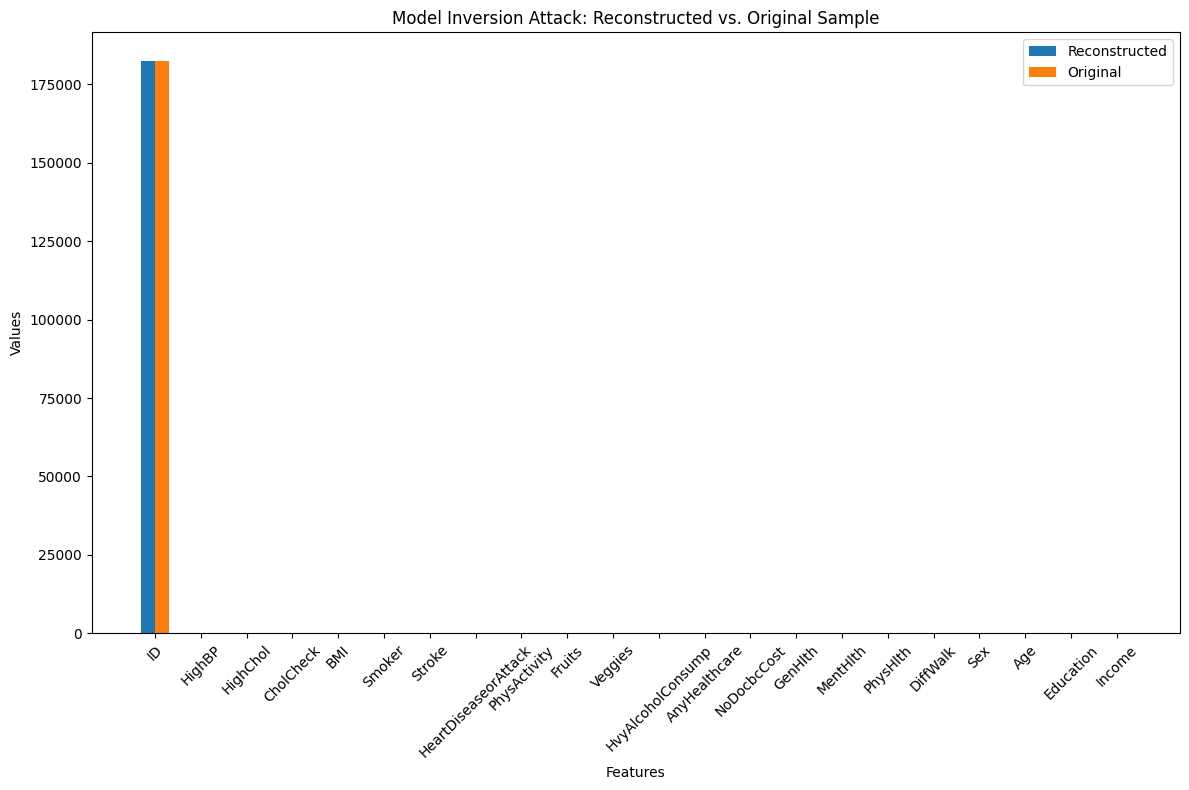


 FEATURE-SPECIFIC ANALYSIS
Feature: ID
  Original value: 182500.00
  Reconstructed value: 182489.00
  Absolute difference: 11.00
  Percentage difference: 0.01%
Feature: HighBP
  Original value: 1.00
  Reconstructed value: 1.00
  Absolute difference: 0.00
  Percentage difference: 0.00%
Feature: HighChol
  Original value: 1.00
  Reconstructed value: 1.00
  Absolute difference: 0.00
  Percentage difference: 0.00%
Feature: CholCheck
  Original value: 1.00
  Reconstructed value: 1.00
  Absolute difference: 0.00
  Percentage difference: 0.00%
Feature: BMI
  Original value: 36.00
  Reconstructed value: 98.00
  Absolute difference: 62.00
  Percentage difference: 172.22%
Feature: Smoker
  Original value: 1.00
  Reconstructed value: 1.00
  Absolute difference: 0.00
  Percentage difference: 0.00%
Feature: Stroke
  Original value: 0.00
  Reconstructed value: 1.00
  Absolute difference: 1.00
  Percentage difference: 0.00%
Feature: HeartDiseaseorAttack
  Original value: 0.00
  Reconstructed value: 

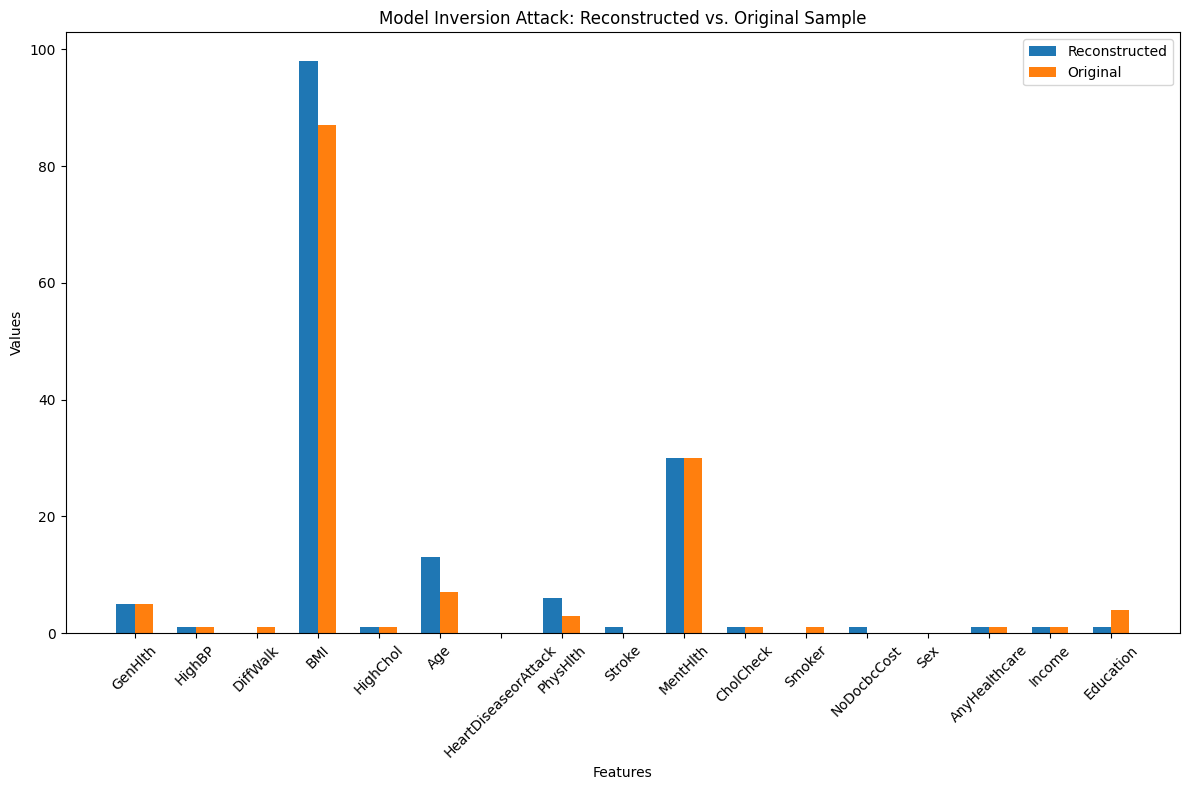


 FEATURE-SPECIFIC ANALYSIS
Feature: GenHlth
  Original value: 5.00
  Reconstructed value: 5.00
  Absolute difference: 0.00
  Percentage difference: 0.00%
Feature: HighBP
  Original value: 1.00
  Reconstructed value: 1.00
  Absolute difference: 0.00
  Percentage difference: 0.00%
Feature: DiffWalk
  Original value: 1.00
  Reconstructed value: 0.00
  Absolute difference: 1.00
  Percentage difference: 100.00%
Feature: BMI
  Original value: 87.00
  Reconstructed value: 98.00
  Absolute difference: 11.00
  Percentage difference: 12.64%
Feature: HighChol
  Original value: 1.00
  Reconstructed value: 1.00
  Absolute difference: 0.00
  Percentage difference: 0.00%
Feature: Age
  Original value: 7.00
  Reconstructed value: 13.00
  Absolute difference: 6.00
  Percentage difference: 85.71%
Feature: HeartDiseaseorAttack
  Original value: 0.00
  Reconstructed value: 0.00
  Absolute difference: 0.00
  Percentage difference: 0.00%
Feature: PhysHlth
  Original value: 3.00
  Reconstructed value: 6.00


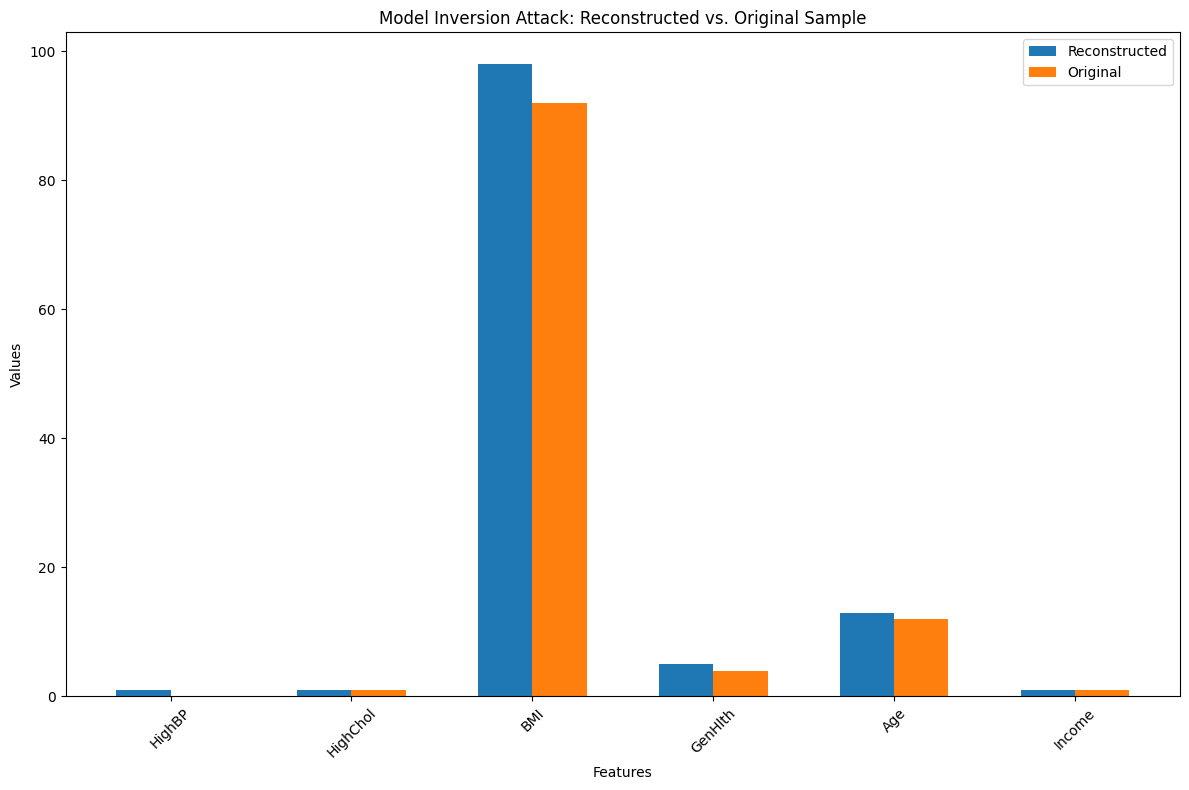


 FEATURE-SPECIFIC ANALYSIS
Feature: HighBP
  Original value: 0.00
  Reconstructed value: 1.00
  Absolute difference: 1.00
  Percentage difference: 0.00%
Feature: HighChol
  Original value: 1.00
  Reconstructed value: 1.00
  Absolute difference: 0.00
  Percentage difference: 0.00%
Feature: BMI
  Original value: 92.00
  Reconstructed value: 98.00
  Absolute difference: 6.00
  Percentage difference: 6.52%
Feature: GenHlth
  Original value: 4.00
  Reconstructed value: 5.00
  Absolute difference: 1.00
  Percentage difference: 25.00%
Feature: Age
  Original value: 12.00
  Reconstructed value: 13.00
  Absolute difference: 1.00
  Percentage difference: 8.33%
Feature: Income
  Original value: 1.00
  Reconstructed value: 1.00
  Absolute difference: 0.00
  Percentage difference: 0.00%

ATTACK EFFECTIVENESS COMPARISON
Model                     Confidence      Similarity     
------------------------- --------------- ---------------
All Features              0.9970          0.0154         
Manual 

In [35]:
def create_scaler_for_model(X_data):
    # Create and fit a StandardScaler for the data
    scaler = StandardScaler()
    scaler.fit(X_data)
    return scaler

# Create scalers for each model
scaler_all = create_scaler_for_model(X_train_bal)
scaler_manSelF = create_scaler_for_model(X_train_bal[manual_important_features])
scaler_selF = create_scaler_for_model(X_train_bal[important_features])

# Run attack on All Features Model
print("\nMODEL INVERSION ATTACK: ALL FEATURES")
results_all = model_inversion_attack_nn(
    model=deepL_model_allF_copy, 
    target_class=1, 
    feature_names=X_train_bal.columns.tolist(), 
    X_train=X_train_bal,
    scaler=scaler_all
)
analyze_model_inversion_attack(results_all, X_train_bal.columns.tolist())

# Run attack on Manual Selected Features Model
print("\nMODEL INVERSION ATTACK: MANUAL SELECTED FEATURES")
results_manSelF = model_inversion_attack_nn(
    model=deepL_model_manSelF_copy, 
    target_class=1, 
    feature_names=manual_important_features, 
    X_train=X_train_bal[manual_important_features],
    scaler=scaler_manSelF
)
analyze_model_inversion_attack(results_manSelF, manual_important_features)

# Run attack on Selected Features Model
print("\nMODEL INVERSION ATTACK: SELECTED FEATURES")
results_selF = model_inversion_attack_nn(
    model=deepL_model_selF_copy, 
    target_class=1, 
    feature_names=important_features, 
    X_train=X_train_bal[important_features],
    scaler=scaler_selF
)
analyze_model_inversion_attack(results_selF, important_features)

# Compare all models
print("\nATTACK EFFECTIVENESS COMPARISON")
print(f"{'Model':<25} {'Confidence':<15} {'Similarity':<15}")
print(f"{'-'*25:<25} {'-'*15:<15} {'-'*15:<15}")
print(f"{'All Features':<25} {results_all['confidence']:<15.4f} {results_all['similarity']:<15.4f}")
print(f"{'Manual Selected Features':<25} {results_manSelF['confidence']:<15.4f} {results_manSelF['similarity']:<15.4f}")
print(f"{'Selected Features':<25} {results_selF['confidence']:<15.4f} {results_selF['similarity']:<15.4f}")

#### 6.2 Membership Inference Attack(MIA) 

---1. Standard MIA---

The goal of this attack is to determine whether a given sample was used in training. 

It queries the model with different data points and analyzes the confidence scores. This happens because the model behaves differently for data it has seen before and new data. As this one was trained without DP, it is easier to leak private data as it may have "memorized" training data. A classification model would classify a training data record to its true class with a high confidence score while classifying a test data record to its true class with a relatively small confidence. These different behaviors of ML models enable an attacker of MIAs to build attack models to distinguish members from non-members of the training dataset.

The more overfitted a machine learning model is, the easier it will be for an adversary to stage membership inference attacks against it. Therefore, a machine model that generalizes well on unseen examples is also more secure against membership inference.

Membership inference attacks are not successful on all kinds of machine learning tasks. To create an efficient attack model, the adversary must be able to explore the feature space. (HigRes. photos: Hard, tabular data: Easy)

** TODO: try with DP model(s) as well **

In [ ]:
# Get models
deepL_model_allF_copy = copy.deepcopy(deepL_model_allF)
deepL_model_manSelF_copy = copy.deepcopy(deepL_model_manSelF)
deepL_model_selF_copy = copy.deepcopy(deepL_model_selF)
deepL_model_allF_dp_copy = copy.deepcopy(deepL_model_allF_dp)
deepL_model_selF_dp_copy = copy.deepcopy(deepL_model_selF_dp)
deepL_model_manSelF_dp_copy = copy.deepcopy(deepL_model_manSelF_dp)

In [ ]:
def evaluate_membership_inference_attack(model, feature_names, X_train, X_test, scaler=None, n_samples=500):
    model.eval()
    
    # Sample from training set
    if len(X_train) > n_samples:
        train_indices = np.random.choice(len(X_train), n_samples, replace=False)
        X_train_sample = X_train.iloc[train_indices]
    else:
        X_train_sample = X_train
        
    # Sample from test set
    if len(X_test) > n_samples:
        test_indices = np.random.choice(len(X_test), n_samples, replace=False)
        X_test_sample = X_test.iloc[test_indices]
    else:
        X_test_sample = X_test
    
    # Get confidence scores for members (training samples)
    member_confidences = []
    for i in range(len(X_train_sample)):
        sample = X_train_sample.iloc[i]
        df_sample = pd.DataFrame([sample])
        sample_data = scaler.transform(df_sample) if scaler else df_sample.values
        sample_tensor = torch.tensor(sample_data, dtype=torch.float32)

        # Get model prediction and confidence
        with torch.no_grad():
            output = model(sample_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence = probabilities[0].max().item()  # max confidence across all classes
        
        member_confidences.append(confidence)
    
    # Get confidence scores for non-members (test samples)
    non_member_confidences = []
    for i in range(len(X_test_sample)):
        sample = X_test_sample.iloc[i]
        df_sample = pd.DataFrame([sample])
        sample_data = scaler.transform(df_sample) if scaler else df_sample.values
        sample_tensor = torch.tensor(sample_data, dtype=torch.float32)

        # Get model prediction and confidence
        with torch.no_grad():
            output = model(sample_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence = probabilities[0].max().item()  # max confidence across all classes
        
        non_member_confidences.append(confidence)
    
    # Calculate metrics at different thresholds
    thresholds = np.linspace(0, 1, 100)
    tpr_list = []  # True Positive Rate
    fpr_list = []  # False Positive Rate
    
    for threshold in thresholds:
        # True positives: members correctly classified as members
        tp = sum(1 for conf in member_confidences if conf > threshold)
        # False negatives: members incorrectly classified as non-members
        fn = sum(1 for conf in member_confidences if conf <= threshold)
        # True negatives: non-members correctly classified as non-members
        tn = sum(1 for conf in non_member_confidences if conf <= threshold)
        # False positives: non-members incorrectly classified as members
        fp = sum(1 for conf in non_member_confidences if conf > threshold)
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    # Create pairs of (fpr, tpr) and sort by fpr for correct AUC calculation
    roc_points = sorted(zip(fpr_list, tpr_list))
    if roc_points:  # Check if roc_points is not empty
        sorted_fpr, sorted_tpr = zip(*roc_points)
        # Calculate ROC AUC correctly
        roc_auc = np.trapz(y=sorted_tpr, x=sorted_fpr)
    else:
        roc_auc = 0.5  # Default to random classifier if no points
    
    # Find optimal threshold (closest point to top-left corner)
    distances = np.sqrt((1 - np.array(tpr_list))**2 + np.array(fpr_list)**2)
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]
    optimal_tpr = tpr_list[optimal_idx]
    optimal_fpr = fpr_list[optimal_idx]
    
    # Calculate accuracy at optimal threshold
    tp = sum(1 for conf in member_confidences if conf > optimal_threshold)
    tn = sum(1 for conf in non_member_confidences if conf <= optimal_threshold)
    accuracy = (tp + tn) / (len(member_confidences) + len(non_member_confidences))
    
    return {
        'member_confidences': member_confidences,
        'non_member_confidences': non_member_confidences,
        'thresholds': thresholds,
        'tpr': tpr_list,
        'fpr': fpr_list,
        'sorted_tpr': sorted_tpr if roc_points else [],
        'sorted_fpr': sorted_fpr if roc_points else [],
        'roc_auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'optimal_tpr': optimal_tpr,
        'optimal_fpr': optimal_fpr,
        'accuracy': accuracy
    }

def plot_membership_inference_results(results, model_name):
    """
    Plot the results of the membership inference attack evaluation.
    
    Parameters:
    - results: Dictionary containing evaluation results
    - model_name: Name of the model for plot titles
    """
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Distribution of confidences
    sns.histplot(results['member_confidences'], color='blue', alpha=0.5, 
                 label='Members (training)', bins=30, kde=True, ax=ax1)
    sns.histplot(results['non_member_confidences'], color='red', alpha=0.5, 
                 label='Non-members (test)', bins=30, kde=True, ax=ax1)
    
    # Add vertical line for optimal threshold
    ax1.axvline(x=results['optimal_threshold'], color='green', linestyle='--', 
                label=f'Optimal threshold: {results["optimal_threshold"]:.3f}')
    
    ax1.set_title(f'Confidence Distribution - {model_name}')
    ax1.set_xlabel('Confidence Score')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    
    # Plot 2: ROC curve
    ax2.plot(results['sorted_fpr'], results['sorted_tpr'], color='blue', lw=2, 
             label=f'ROC curve (AUC = {results["roc_auc"]:.3f})')
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax2.scatter([results['optimal_fpr']], [results['optimal_tpr']], color='red', s=100, 
                label=f'Optimal (TPR={results["optimal_tpr"]:.3f}, FPR={results["optimal_fpr"]:.3f})')
    
    ax2.set_title(f'ROC Curve - {model_name}')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

def evaluate_and_compare_models(models_dict, X_train, X_test, feature_sets, scalers):

    results = {}
    
    for model_name, model in models_dict.items():
        features = feature_sets[model_name]
        scaler = scalers[model_name]
        
        print(f"\nEvaluating model: {model_name}")
        model_results = evaluate_membership_inference_attack(
            model=model,
            feature_names=features,
            X_train=X_train[features],
            X_test=X_test[features],  # Use features subset for test data too
            scaler=scaler
        )
        
        results[model_name] = model_results
        plot_membership_inference_results(model_results, model_name)
    
    return results

def plot_comparison_metrics(results_dict):
    """
    Create a comparative visualization of model privacy metrics.
    
    Parameters:
    - results_dict: Dictionary mapping model names to evaluation results
    """
    # Extract metrics for comparison
    model_names = list(results_dict.keys())
    auc_values = [results_dict[name]['roc_auc'] for name in model_names]
    accuracy_values = [results_dict[name]['accuracy'] for name in model_names]
    
    # Organize into non-DP and DP categories
    non_dp_names = [name for name in model_names if '_dp' not in name]
    dp_names = [name for name in model_names if '_dp' in name]
    
    if not non_dp_names or not dp_names:  # Check if either list is empty
        print("Warning: Unable to split models into DP and non-DP groups for comparison")
        return
        
    non_dp_auc = [results_dict[name]['roc_auc'] for name in non_dp_names]
    dp_auc = [results_dict[name]['roc_auc'] for name in dp_names]
    
    non_dp_acc = [results_dict[name]['accuracy'] for name in non_dp_names]
    dp_acc = [results_dict[name]['accuracy'] for name in dp_names]
    
    # Create figure for comparison plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: AUC comparison
    x = np.arange(len(non_dp_names))
    width = 0.35
    
    ax1.bar(x - width/2, non_dp_auc, width, label='Without DP', color='blue', alpha=0.7)
    ax1.bar(x + width/2, dp_auc, width, label='With DP', color='red', alpha=0.7)
    
    ax1.set_ylabel('ROC AUC')
    ax1.set_title('Attack Effectiveness (ROC AUC)')
    ax1.set_xticks(x)
    ax1.set_xticklabels([name.replace('_copy', '') for name in non_dp_names])
    ax1.legend()
    
    # Add value labels on bars
    for i, v in enumerate(non_dp_auc):
        ax1.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')
    for i, v in enumerate(dp_auc):
        ax1.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')
    
    # Plot 2: Accuracy comparison
    ax2.bar(x - width/2, non_dp_acc, width, label='Without DP', color='blue', alpha=0.7)
    ax2.bar(x + width/2, dp_acc, width, label='With DP', color='red', alpha=0.7)
    
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Attack Accuracy')
    ax2.set_xticks(x)
    ax2.set_xticklabels([name.replace('_copy', '') for name in non_dp_names])
    ax2.legend()
    
    # Add value labels on bars
    for i, v in enumerate(non_dp_acc):
        ax2.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')
    for i, v in enumerate(dp_acc):
        ax2.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Create a summary table
    print("\nMEMBERSHIP INFERENCE ATTACK COMPARISON")
    print(f"{'Model':<25} {'ROC AUC':<15} {'Accuracy':<15} {'Optimal Threshold':<20}")
    print(f"{'-'*25:<25} {'-'*15:<15} {'-'*15:<15} {'-'*20:<20}")
    
    for name in model_names:
        print(f"{name:<25} {results_dict[name]['roc_auc']:<15.4f} "
              f"{results_dict[name]['accuracy']:<15.4f} "
              f"{results_dict[name]['optimal_threshold']:<20.4f}")

# Import necessary libraries
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Organize models, features, and scalers
models = {
    'allF': deepL_model_allF_copy,
    'allF_dp': deepL_model_allF_dp_copy,
    'manSelF': deepL_model_manSelF_copy,
    'manSelF_dp': deepL_model_manSelF_dp_copy,
    'selF': deepL_model_selF_copy,
    'selF_dp': deepL_model_selF_dp_copy
}

feature_sets = {
    'allF': X_train_bal.columns.tolist(),
    'allF_dp': X_train_bal.columns.tolist(),
    'manSelF': manual_important_features,
    'manSelF_dp': manual_important_features,
    'selF': important_features,
    'selF_dp': important_features
}

scalers = {
    'allF': scaler_all,
    'allF_dp': scaler_all,
    'manSelF': scaler_manSelF,
    'manSelF_dp': scaler_manSelF,
    'selF': scaler_selF,
    'selF_dp': scaler_selF
}

# Run the evaluation - USING X_test_bal INSTEAD OF X_test!
print("\nRUNNING COMPREHENSIVE MEMBERSHIP INFERENCE ATTACK EVALUATION")
results = evaluate_and_compare_models(models, X_train_bal, X_test_bal, feature_sets, scalers)

# Plot comparison
plot_comparison_metrics(results)

As features are reduced, attack confidence drops, but similarity increases. This means that fewer, well-chosen features let the attack reconstruct samples closer to reality, even if less sure. The selected features expose more structure for the attacker.

TODO: maybe add the data of each reconstructed member in the output

--- 2. Real World Case MIA ---

In [ ]:
def membership_inference_attack_practical(models, feature_sets, scalers, X_train_bal, X_test_bal, num_subjects=10):
    
    # Calculate attack thresholds
    thresholds = {}
    
    for model_name, model in models.items():
        features = feature_sets[model_name]
        scaler = scalers[model_name]
        
        # Ensure features exist
        available_features = [f for f in features if f in X_train_bal.columns]
        if len(available_features) != len(features):
            continue
        
        # Get member/non-member samples
        train_sample = X_train_bal[available_features].sample(500) if len(X_train_bal) > 500 else X_train_bal[available_features]
        test_sample = X_test_bal[available_features].sample(500) if len(X_test_bal) > 500 else X_test_bal[available_features]
        
        # Calculate confidence scores
        train_confidences = []
        test_confidences = []
        
        for i in range(len(train_sample)):
            try:
                sample = train_sample.iloc[i]
                df_sample = pd.DataFrame([sample])
                sample_data = scaler.transform(df_sample) if scaler else df_sample.values
                sample_tensor = torch.tensor(sample_data, dtype=torch.float32)
                
                with torch.no_grad():
                    output = model(sample_tensor)
                    probabilities = torch.nn.functional.softmax(output, dim=1)
                    confidence = probabilities[0].max().item()
                
                train_confidences.append(confidence)
            except Exception:
                continue
        
        for i in range(len(test_sample)):
            try:
                sample = test_sample.iloc[i]
                df_sample = pd.DataFrame([sample])
                sample_data = scaler.transform(df_sample) if scaler else df_sample.values
                sample_tensor = torch.tensor(sample_data, dtype=torch.float32)
                
                with torch.no_grad():
                    output = model(sample_tensor)
                    probabilities = torch.nn.functional.softmax(output, dim=1)
                    confidence = probabilities[0].max().item()
                
                test_confidences.append(confidence)
            except Exception:
                continue
        
        if not train_confidences or not test_confidences:
            continue
            
        # Find optimal threshold
        thresholds_list = np.linspace(0, 1, 100)
        best_threshold = 0.5
        best_distance = float('inf')
        
        for threshold in thresholds_list:
            tpr = sum(1 for conf in train_confidences if conf > threshold) / len(train_confidences)
            fpr = sum(1 for conf in test_confidences if conf > threshold) / len(test_confidences)
            distance = np.sqrt((1 - tpr)**2 + fpr**2)
            
            if distance < best_distance:
                best_distance = distance
                best_threshold = threshold
        
        thresholds[model_name] = best_threshold
    
    if not thresholds:
        print("No models could be evaluated.")
        return {}, {}, {}
    
    # Get subjects for analysis
    known_members = X_train_bal.sample(num_subjects // 2) if len(X_train_bal) >= num_subjects // 2 else X_train_bal
    known_non_members = X_test_bal.sample(num_subjects // 2) if len(X_test_bal) >= num_subjects // 2 else X_test_bal
    
    all_subjects = pd.concat([known_members, known_non_members], ignore_index=True)
    subject_true_status = [True] * len(known_members) + [False] * len(known_non_members)
    
    # Run attack
    
    # Store results
    subject_predictions = {model_name: [] for model_name in thresholds.keys()}
    
    # Process each subject
    for i, (_, subject_data) in enumerate(all_subjects.iterrows()):
        for model_name, model in models.items():
            if model_name not in thresholds:
                continue
                
            features = feature_sets[model_name]
            scaler = scalers[model_name]
            threshold = thresholds[model_name]
            
            try:
                # Prepare data
                filtered_data = {feature: subject_data[feature] for feature in features if feature in subject_data}
                if len(filtered_data) != len(features):
                    continue
                    
                df_sample = pd.DataFrame([filtered_data])
                sample_data = scaler.transform(df_sample) if scaler else df_sample.values
                sample_tensor = torch.tensor(sample_data, dtype=torch.float32)
                
                # Get prediction
                with torch.no_grad():
                    output = model(sample_tensor)
                    probabilities = torch.nn.functional.softmax(output, dim=1)
                    confidence = probabilities[0].max().item()
                
                # Determine membership
                is_member = confidence > threshold
                
                # Add to predictions
                subject_predictions[model_name].append((is_member, subject_true_status[i]))
                
            except Exception:
                continue
    
    # Calculate metrics
    success_rates = {}
    true_positive_rates = {}
    true_negative_rates = {}
    
    for model_name, predictions in subject_predictions.items():
        if not predictions:
            continue
            
        # Overall success rate
        correct = sum(1 for pred, actual in predictions if pred == actual)
        total = len(predictions)
        success_rate = correct / total if total > 0 else 0
        
        # True positive rate
        true_positives = sum(1 for pred, actual in predictions if pred and actual)
        actual_positives = sum(1 for _, actual in predictions if actual)
        tpr = true_positives / actual_positives if actual_positives > 0 else 0
        
        # True negative rate
        true_negatives = sum(1 for pred, actual in predictions if not pred and not actual)
        actual_negatives = sum(1 for _, actual in predictions if not actual)
        tnr = true_negatives / actual_negatives if actual_negatives > 0 else 0
        
        success_rates[model_name] = success_rate
        true_positive_rates[model_name] = tpr
        true_negative_rates[model_name] = tnr
    
    # Separate DP and non-DP models
    dp_models = [name for name in success_rates.keys() if '_dp' in name]
    non_dp_models = [name for name in success_rates.keys() if '_dp' not in name]
    
    dp_rates = [success_rates[name] for name in dp_models]
    non_dp_rates = [success_rates[name] for name in non_dp_models]
    
    avg_dp_success = sum(dp_rates) / len(dp_rates) if dp_rates else 0
    avg_non_dp_success = sum(non_dp_rates) / len(non_dp_rates) if non_dp_rates else 0
    
    # Output results table
    print("\nAttack Results:")
    print("-" * 60)
    print(f"{'Model':<12} {'Type':<8} {'Success %':<10} {'TPR %':<10} {'TNR %':<10}")
    print("-" * 60)
    
    for name in sorted(success_rates.keys()):
        model_type = "With DP" if '_dp' in name else "No DP"
        success = success_rates[name] * 100
        tpr = true_positive_rates[name] * 100
        tnr = true_negative_rates[name] * 100
        
        print(f"{name:<12} {model_type:<8} {success:>8.1f}% {tpr:>8.1f}% {tnr:>8.1f}%")
    
    print("-" * 60)
    print(f"{'Avg No DP':<12} {'':8} {avg_non_dp_success*100:>8.1f}%")
    print(f"{'Avg With DP':<12} {'':8} {avg_dp_success*100:>8.1f}%")
    print(f"{'Improvement':<12} {'':8} {(avg_non_dp_success-avg_dp_success)*100:>8.1f}%")
    print("-" * 60)
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    
    # Prepare data
    x_pos = np.arange(len(success_rates))
    model_names = list(success_rates.keys())
    rates = [success_rates[name] * 100 for name in model_names]
    colors = ['#3498db' if '_dp' not in name else '#e74c3c' for name in model_names]
    
    # Create chart
    bars = plt.bar(x_pos, rates, color=colors)
    
    # Add labels
    plt.xlabel('Model')
    plt.ylabel('Attack Success Rate (%)')
    plt.title('Membership Inference Attack Success Rate by Model')
    plt.xticks(x_pos, model_names, rotation=45)
    
    # Add legend
    import matplotlib.patches as mpatches
    blue_patch = mpatches.Patch(color='#3498db', label='No DP')
    red_patch = mpatches.Patch(color='#e74c3c', label='With DP')
    plt.legend(handles=[blue_patch, red_patch])
    
    # Add bar labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom')
    
    # Add reference lines
    plt.axhline(y=50, color='gray', linestyle='--')
    plt.axhline(y=avg_non_dp_success * 100, color='#3498db', linestyle='-', alpha=0.3)
    plt.axhline(y=avg_dp_success * 100, color='#e74c3c', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nConclusion:")
    privacy_improvement = avg_non_dp_success - avg_dp_success
    
    if privacy_improvement > 0.05:
        print(f"Differential privacy improves privacy protection by {privacy_improvement*100:.1f}%")
    elif privacy_improvement > 0:
        print(f"Differential privacy provides modest protection ({privacy_improvement*100:.1f}% improvement)")
    else:
        print("Current differential privacy implementation doesn't show privacy benefits")
    
    return success_rates, true_positive_rates, true_negative_rates

# Call the function
attack_success, attack_tpr, attack_tnr = membership_inference_attack_practical(
    models,
    feature_sets,
    scalers,
    X_train_bal,
    X_test_bal,
    num_subjects=10
)

<!-- #### 6.3 Attribute Inference Attack -->

In [ ]:
# # Get models
# deepL_model_allF_copy = copy.deepcopy(deepL_model_allF)
# deepL_model_manSelF_copy = copy.deepcopy(deepL_model_manSelF)
# deepL_model_selF_copy = copy.deepcopy(deepL_model_selF)

In [ ]:
# from tabulate import tabulate

# assert 'rf_model' in locals(), "Deep Learning model (rf_model) is not defined!" #if not defined, run 6.6

# sensitive_feature = 'Income'

# # Exclude 'Income' from training features - because we will be trying to infer this attribute
# attack_features = [f for f in X_train.columns if f != sensitive_feature]

# # Get confidence scores from the target model
# # For each prediction, predict_proba() gives an array of probabilities for each class (8 in case of Income)
# train_confidences = rf_model.predict_proba(X_train).max(axis=1)
# test_confidences = rf_model.predict_proba(X_test).max(axis=1)

# # Add confidence scores to the dataset
# X_train_attack = X_train[attack_features].copy()
# X_train_attack['model_confidence'] = train_confidences

# X_test_attack = X_test[attack_features].copy()
# X_test_attack['model_confidence'] = test_confidences


# y_train_attack = X_train[sensitive_feature]
# y_test_attack = X_test[sensitive_feature]

# # Train the Inference Model (using deep learning)
# rf_model.fit(X_train_attack, y_train_attack)

# # Evaluate the Inference Model
# y_pred_attack = rf_model.predict(X_test_attack)

# attack_accuracy = accuracy_score(y_test_attack, y_pred_attack)

# train_mean_conf = np.mean(train_confidences)
# test_mean_conf = np.mean(test_confidences)

# print("\nAttribute Inference Attack on 'Income':")
# print(f"Attack Accuracy: {attack_accuracy:.2f}")
# print(f"Avg Train Confidence: {train_mean_conf:.2f}")
# print(f"Avg Test Confidence: {test_mean_conf:.2f}\n")

# report = classification_report(y_test_attack, y_pred_attack, output_dict=True)

# def print_classification_report(report):
#     headers = ["Metric"] + [str(label) for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')]
#     rows = [
#         ["Precision"] + [report[label]['precision'] for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')],
#         ["Recall"] + [report[label]['recall'] for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')],
#         ["F1-Score"] + [report[label]['f1-score'] for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')],
#         ["Support"] + [report[label]['support'] for label in report if label not in ('accuracy', 'macro avg', 'weighted avg')]
#     ]

#     # Add macro and weighted averages
#     rows.append(["Macro Avg", report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'], report['macro avg']['support']])
#     rows.append(["Weighted Avg", report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'], report['weighted avg']['support']])
#     rows.append(["Accuracy", "", "", report['accuracy'], ""])

#     print(tabulate(rows, headers=headers, tablefmt="grid", floatfmt=".2f"))

# plt.figure(figsize=(10, 7))
# plt.hist(train_confidences, bins=50, alpha=0.6, label="Train (Member)", color='blue')
# plt.hist(test_confidences, bins=50, alpha=0.6, label="Test (Non-Member)", color='red')
# plt.axvline(train_mean_conf, color='blue', linestyle='dashed', linewidth=1, label=f"Mean Train Confidence: {train_mean_conf:.2f}")
# plt.axvline(test_mean_conf, color='red', linestyle='dashed', linewidth=1, label=f"Mean Test Confidence: {test_mean_conf:.2f}")
# plt.xlabel("Model Confidence Score")
# plt.ylabel("Count")
# plt.legend()
# plt.title("Attribute Inference Attack - Confidence Distribution")
# plt.show()


The attack achieved 47% accuracy, meaning it correctly inferred the income level of individuals nearly half the time. As the Income attribute has 8 levels, it is normal that the accuracy is lower. If the attack tried to guess randomly, it would be around 12,5% (1/8 *100). Therefore data is leaking. 

Also, the model showed higher confidence on training data (0.91) than test data (0.83), indicating a potential privacy risk.

<!-- #### 6.4 Find most exposed individuals and the analyzing the infered data -->

In [ ]:
# # Add predictions and confidence to the test dataset for analysis
# vulnerable_data = X_test_attack.copy()
# vulnerable_data['True_Income'] = y_test_attack.values
# vulnerable_data['Predicted_Income'] = y_pred_attack

# # Calculate prediction correctness
# vulnerable_data['Correct_Prediction'] = (vulnerable_data['True_Income'] == vulnerable_data['Predicted_Income'])

# # Fidn top 20 most vulnerable individuals (highest confidence)
# most_vulnerable = vulnerable_data.sort_values(by='model_confidence', ascending=False).head(20)

# print("Most Vulnerable Individuals (Top 20 by Confidence Score):")
# print(tabulate(most_vulnerable[['model_confidence', 'True_Income', 'Predicted_Income', 'Correct_Prediction']],
#                headers='keys', tablefmt='pretty'))

The 20 most vulnerable individuals had a model confidence of 1.0, meaning the model was completely certain about their predicted income. 16 out of 20 predictions were completely correct (80%), highlighting a significant privacy concern for these individuals.

## 7 . Evaluation & Performance Metrics

Missing

## 8 . Results & Discussion

Missing

## 9 . Conclusion & Future Work

Missing